# Limpieza y estandarización de datos

In [1]:
import pandas as pd

df = pd.read_csv("../data/df_propuesto.csv")
df

id                                              title  \
0    MCO1312345739                     Cerca 75km - Ganado - Impulsor   
1    MCO1401210195      Planta Cerca Electrica Para Ganado 50km M. Jr   
2     MCO601595467  Limpiador  Electrónico -removedor De Polvo - A...   
3     MCO611865640  Planta Cerca Eléctrica Solar 100km, Incluye Pa...   
4     MCO599963912  Tensor Metálico Para Cerca Eléctrica Para 500 ...   
..             ...                                                ...   
995   MCO542097832  Gripple Plus Medium Pack De 20 | Alambre Joine...   
996   MCO542414089  Presurizador Bomba Automatico Soluciona La Baj...   
997   MCO542469534  8,5 X 11 Sostenedor De La Muestra De Acrílico ...   
998   MCO542656528  Fantasia Walt Disney Video Laserdisc- Musical ...   
999   MCO542909729  Medidor De Alto Voltaje Para Cerca Eléctrica 1...   

                                             thumbnail   price  \
0    http://http2.mlstatic.com/D_926804-MCO70350738...  165000   
1    http://http2.mlstatic.com/D_802783-MCO74899505...  140000   
2    http://http2.mlstatic.com/D_995727-MCO73203873...   21500   
3    http://http2.mlstatic.com/D_844953-MCO45203598...  690000   
4    http://http2.mlstatic.com/D_797256-MCO71264690...    6600   
..                                                 ...     ...   
995  http://http2.mlstatic.com/D_926412-MCO44224848...  274000   
996  http://http2.mlstatic.com/D_914137-MCO45760245...  379999   
997  http://http2.mlstatic.com/D_864629-MCO40475967...  210000   
998  http://http2.mlstatic.com/D_841362-MCO28010690...   55000   
999  http://http2.mlstatic.com/D_636667-MCO69785957...   64000   

                     brand                        gtin  
0       CERCAS DEL ORIENTE   000223213232,000055393829  
1       JR CERCA ELECTRICA                         NaN  
2              ABRO DUSTER                         NaN  
3    UNIVERSAL ELECTRÓNICS                         NaN  
4                   Luxury               7707314156920  
..                     ...                         ...  
995      Yardware etcetera  672205002204,0672205002204  
996                  Dmgas                         NaN  
997               Arraview  605930132700,0605930132700  
998                    NaN                         NaN  
999                    NaN                         NaN  

[1000 rows x 6 columns]

# Limpieza y Estandarización de brand (Marca)

## Normalizar mayúsculas/minúsculas
Convierte todas las marcas a **mayúsculas** o **minúsculas** de manera uniforme.  
**Ejemplo:**  
“Luxury” y “LUXURY” se transforman en **“LUXURY”**.

## Eliminar tildes y caracteres especiales
Reemplaza o elimina acentos (á, é, í, ó, ú) y cualquier símbolo extraño para evitar duplicados debidos a errores de codificación.  
**Ejemplo:**  
**“ELÉCTRONICS”** → **“ELECTRONICS”**.

## Reducir espacios en blanco
Quita espacios múltiples o los que sobran al inicio/fin de la cadena.  
**Ejemplo:**  
**“ JR CERCA ELECTRICA ”** → **“JR CERCA ELECTRICA”**.

## Unificar variaciones menores
Si se detectan diferencias leves (ej. “inti” vs “Inti”), se convergen en una misma marca (“INTI”).  
Se puede usar un diccionario de sinónimos o equivalencias si se conocen casos frecuentes.  
**Ejemplo:**  
**“Genérica”** y **“Generica”** → **“Generico”**.

## Posible uso de fuzzy matching
Cuando hay marcas escritas de forma muy diferente (por ejemplo, “ARROWW” vs “ARROW”), se puede recurrir a algoritmos de similaridad de strings como **Levenshtein** o **Soundex** para unificarlas si la distancia es pequeña.


In [5]:
import unicodedata
import spacy

# Carga el modelo de spaCy en español:
nlp = spacy.load("es_core_news_sm")

# Diccionario de equivalencias para unificar valores similares
brand_synonyms = {
    "genérica": "generico",
    "generica": "generico",
    "jr cerca electrica": "jr cerca eléctrica",
    "jr cerca eléctrica": "jr cerca eléctrica",
    # Agrega más casos según tu dominio...
}

def remove_accents(input_str):
    """
    Elimina acentos y diacríticos de una cadena usando unicodedata.normalize.
    """
    if not isinstance(input_str, str):
        return input_str
    
    nfkd_form = unicodedata.normalize('NFD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

def standardize_brand(brand_value, do_lemmatize=False):
    """
    Estandariza el valor de la marca:
      1) Quita espacios sobrantes
      2) Convierte a minúsculas
      3) Elimina acentos/caracteres especiales
      4) Aplica diccionario de sinónimos
      5) (Opcional) Lematiza con spaCy
      6) Retorna en minúsculas
    """
    if not isinstance(brand_value, str) or not brand_value.strip():
        return None  # Para valores nulos o vacíos
    
    # 1) Quitar espacios al inicio/fin
    brand_clean = brand_value.strip()
    
    # 2) Convertir a minúsculas
    brand_clean = brand_clean.lower()
    
    # 3) Eliminar acentos/caracteres no deseados
    brand_clean = remove_accents(brand_clean)
    
    # 4) Unificar mediante diccionario de sinónimos si aplica
    if brand_clean in brand_synonyms:
        brand_clean = brand_synonyms[brand_clean]
    
    # 5) Lematizar (opcional)
    if do_lemmatize:
        doc = nlp(brand_clean)
        # Reemplaza la marca con la concatenación de las lemas de cada token
        # (generalmente será una palabra, pero puede tener varias).
        brand_clean = " ".join([token.lemma_ for token in doc])
    
    # 6) Retornar en minúsculas
    return brand_clean.lower()

# =========================
# EJEMPLO DE USO
# =========================
# Supongamos que df['brand'] contiene marcas sin estandarizar:
# df['brand_std'] será la nueva columna con la marca estandarizada sin lematización.
df['brand_std'] = df['brand'].apply(standardize_brand)

# O si deseas lematizar:
# df['brand_std_lemma'] = df['brand'].apply(lambda x: standardize_brand(x, do_lemmatize=True))

print(df[['brand', 'brand_std']].head(20))


                       brand                 brand_std
0         CERCAS DEL ORIENTE        cercas del oriente
1         JR CERCA ELECTRICA        jr cerca eléctrica
2                ABRO DUSTER               abro duster
3      UNIVERSAL ELECTRÓNICS     universal electronics
4                     Luxury                    luxury
5              Made in China             made in china
6                   Excelite                  excelite
7                     Luxury                    luxury
8                     Luxury                    luxury
9                     Luxury                    luxury
10                    Luxury                    luxury
11                  Cauchope                  cauchope
12                       NaN                      None
13                      Bold                      bold
14  CERCAS ELECTRICAS DORADA  cercas electricas dorada
15                       E&L                       e&l
16                     Tonic                     tonic
17        

In [6]:
brand_counts = df['brand_std'].value_counts().reset_index()
brand_counts.columns = ['brand_std', 'count']
brand_counts

brand_std  count
0                 luxury    135
1                  alpha     36
2                   inti     32
3               generico     32
4    del agro soluciones     29
..                   ...    ...
435                  xpg      1
436              remotec      1
437             paladone      1
438            agrofacil      1
439               velcro      1

[440 rows x 2 columns]


=== Marca: 'luxury' (Total productos: 135) ===


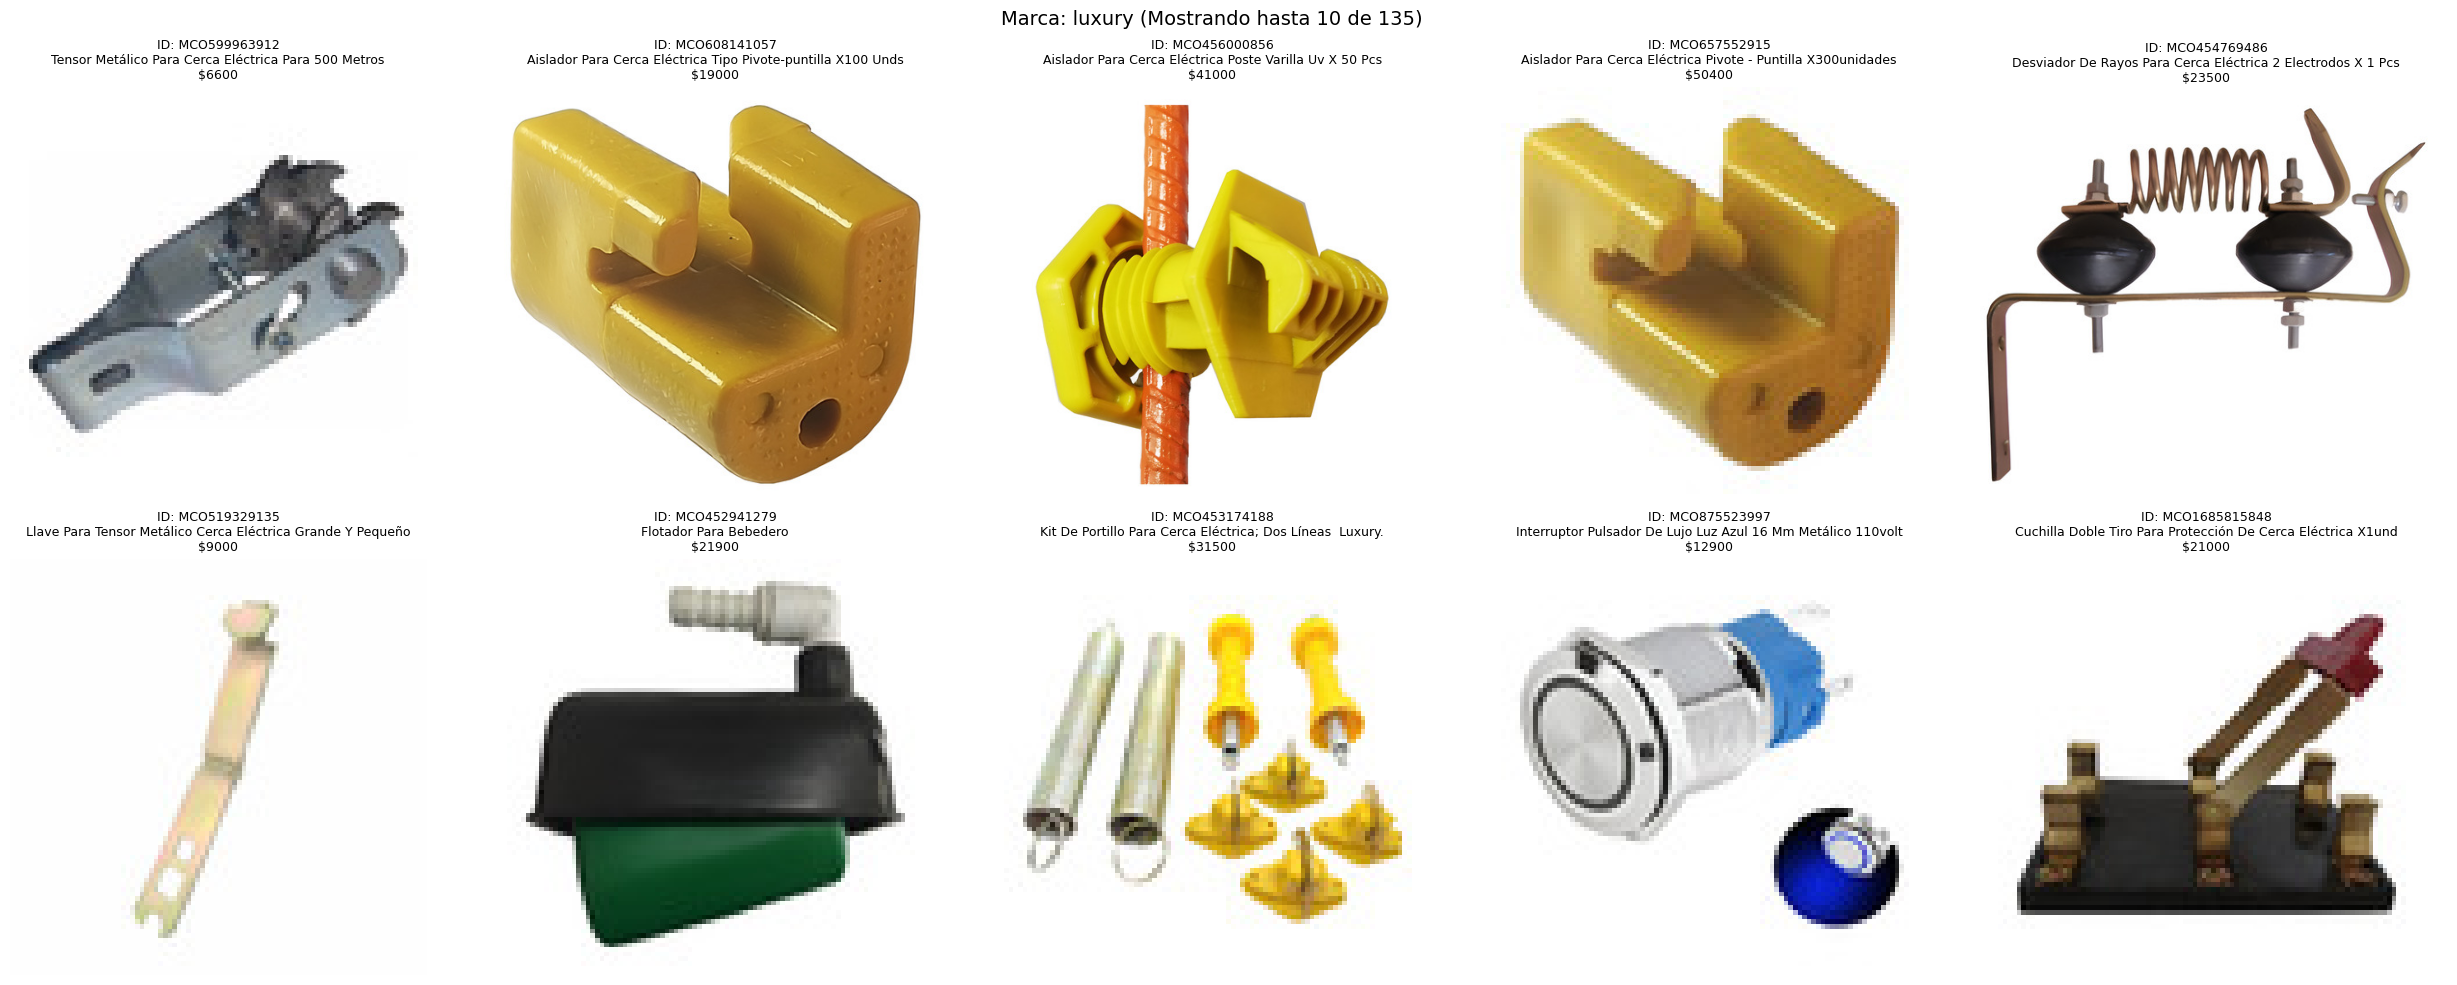


=== Marca: 'alpha' (Total productos: 36) ===


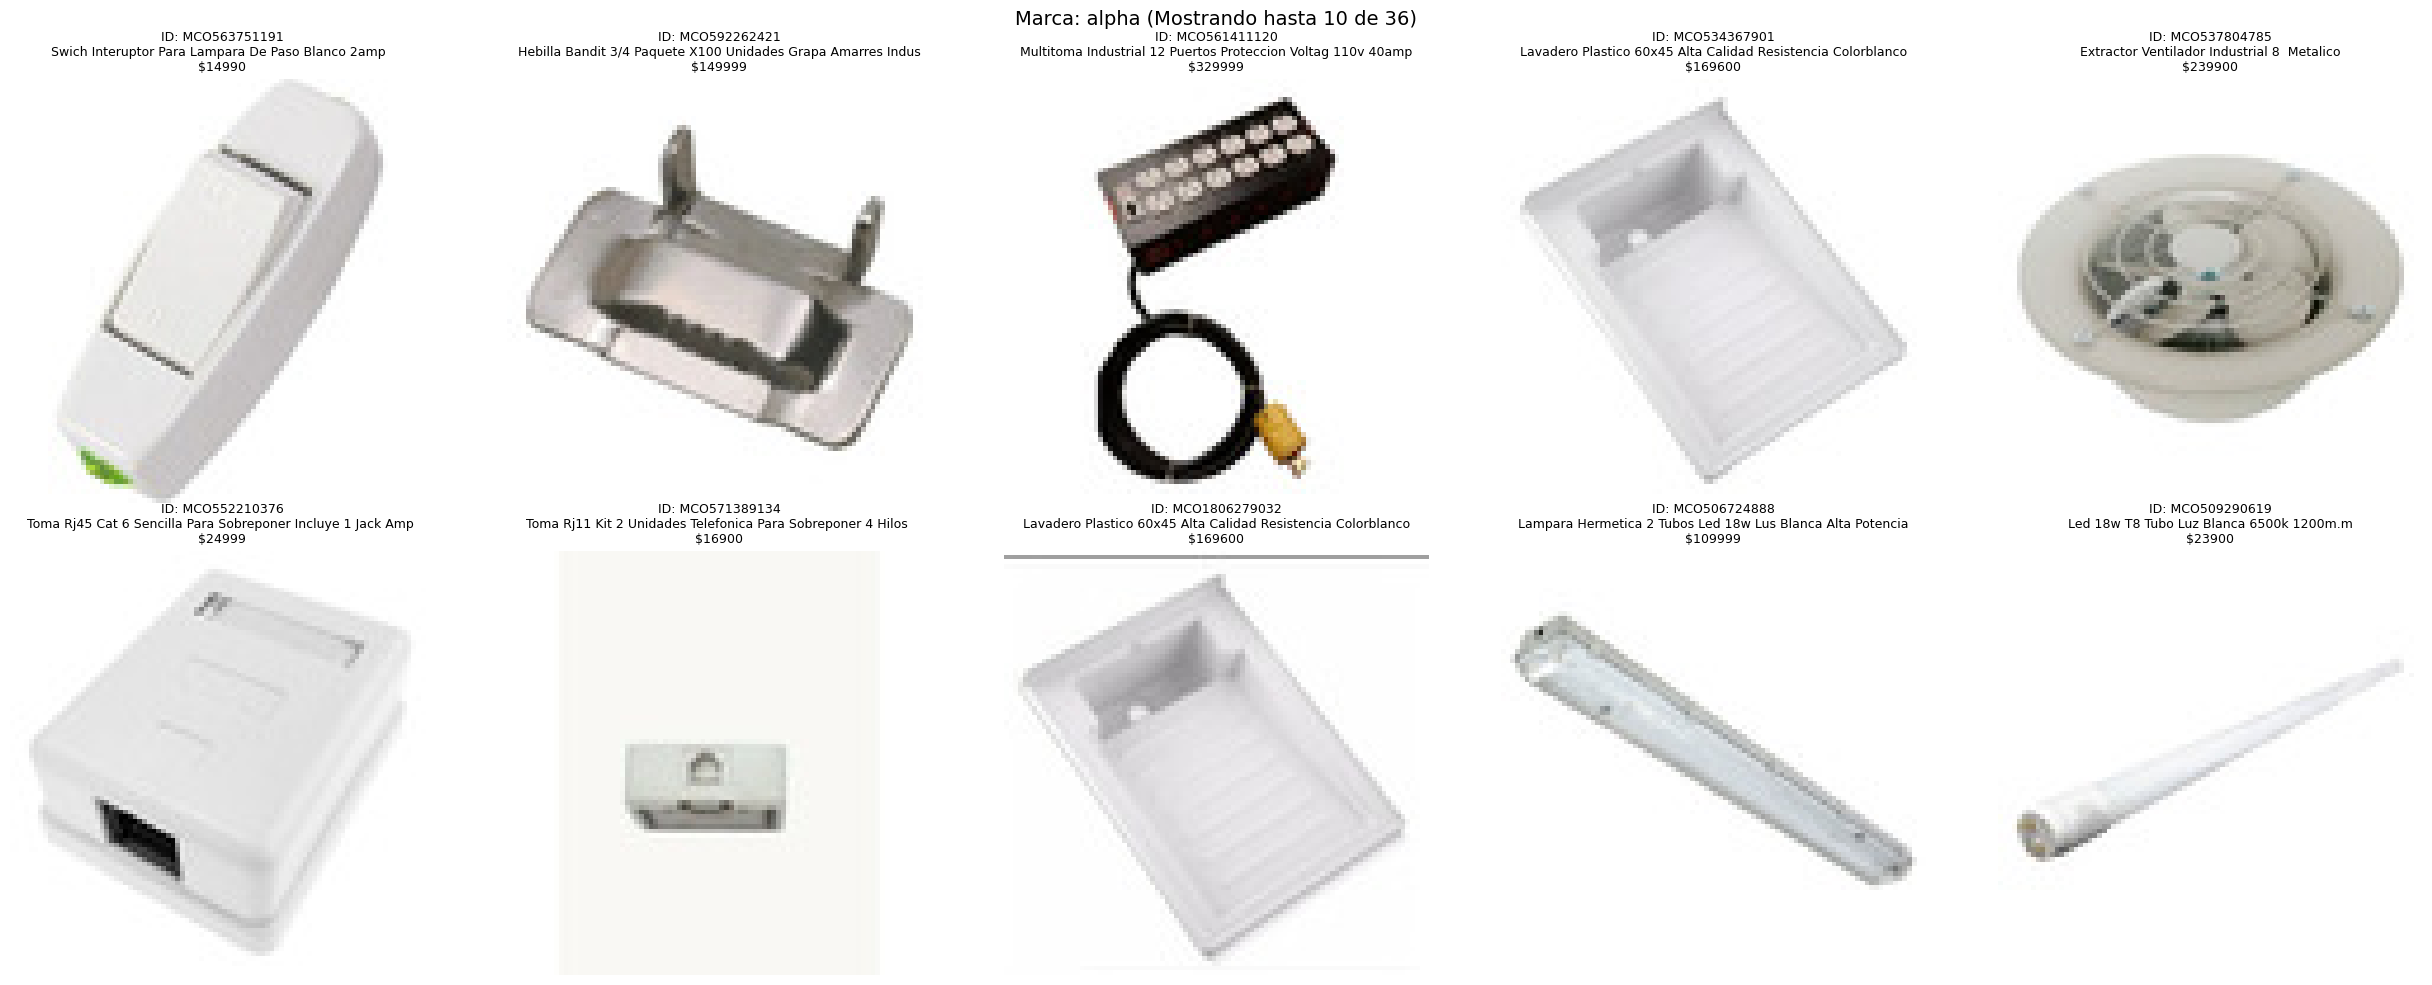


=== Marca: 'inti' (Total productos: 32) ===


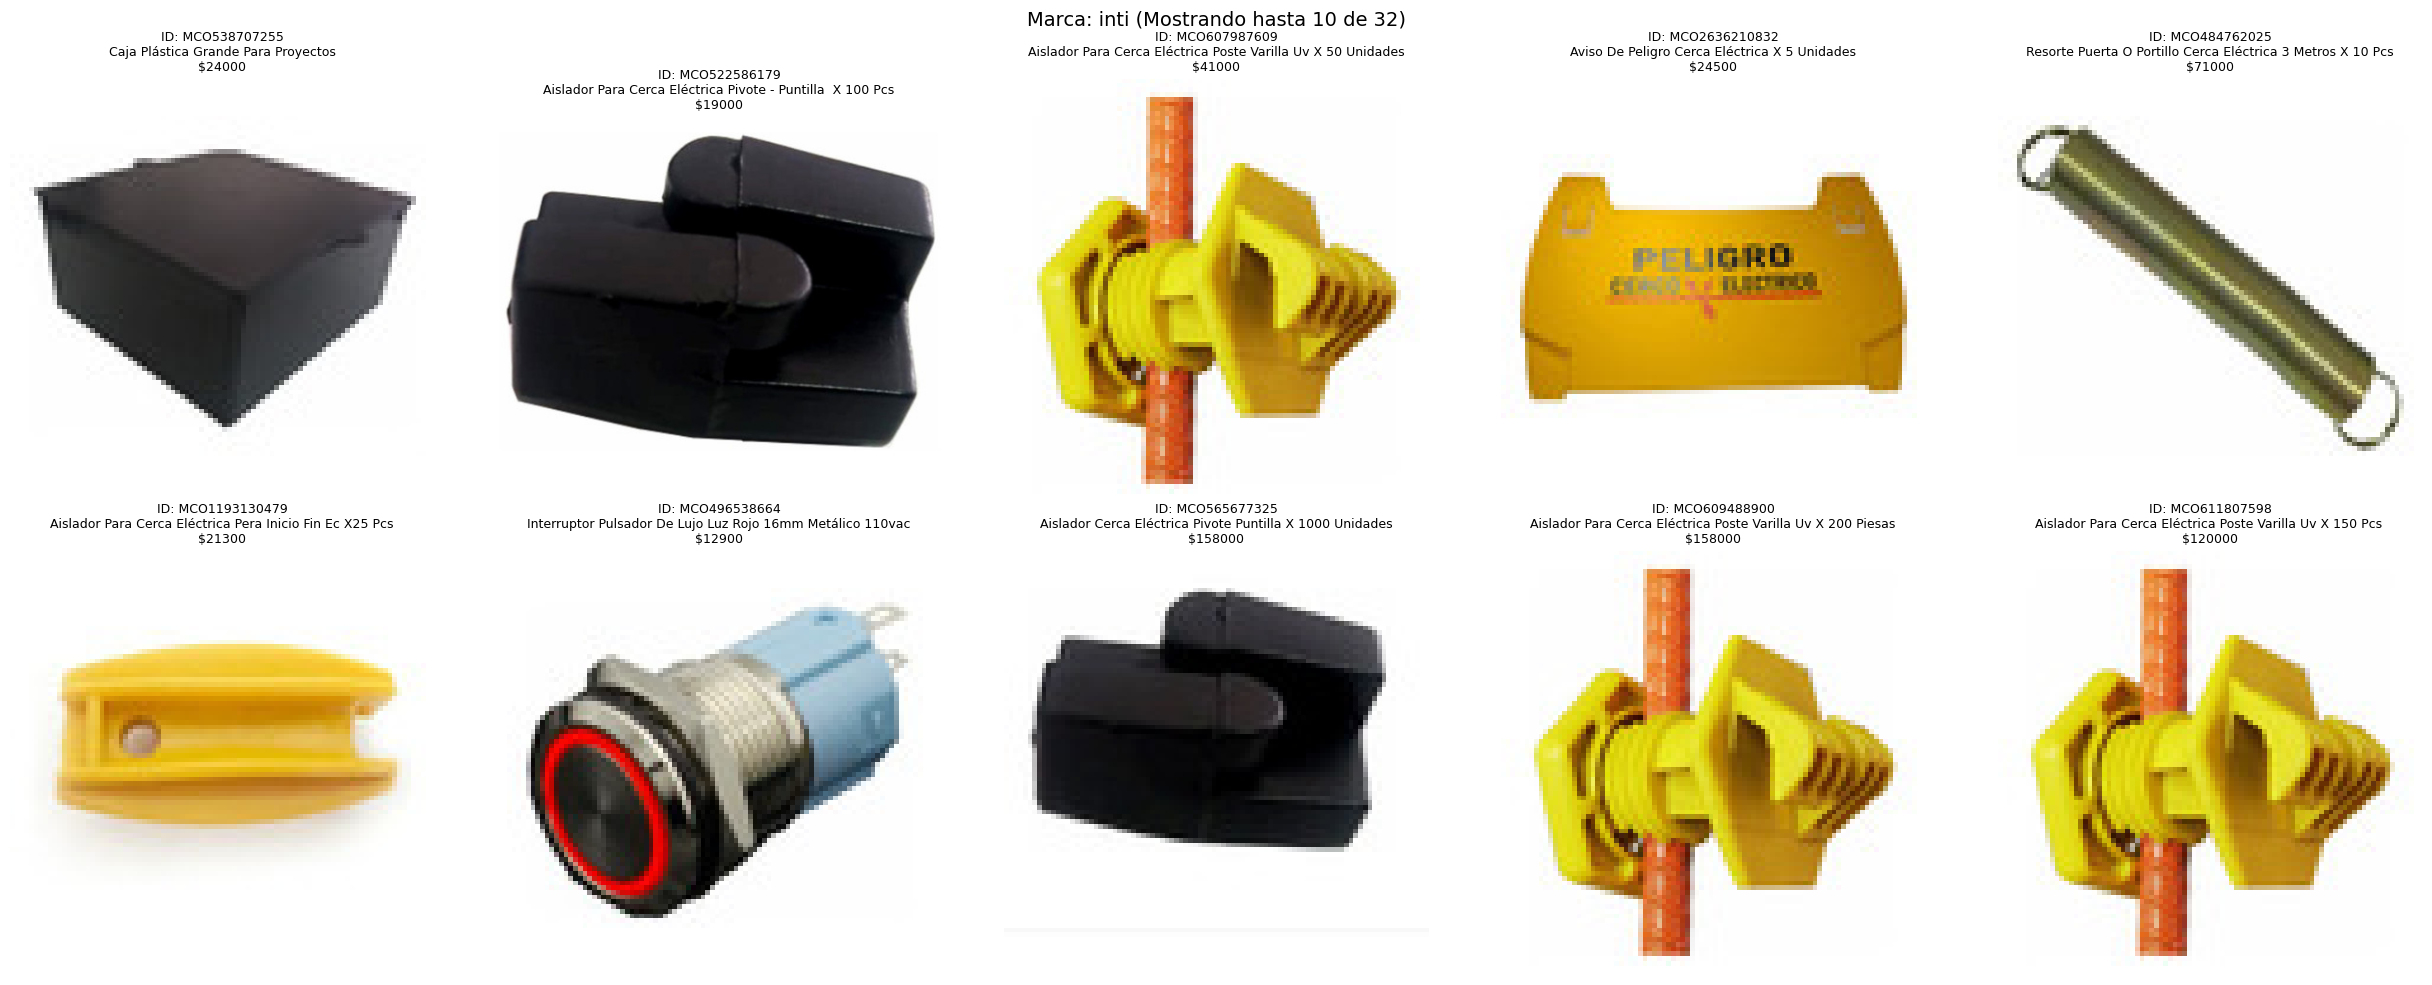


=== Marca: 'generico' (Total productos: 32) ===


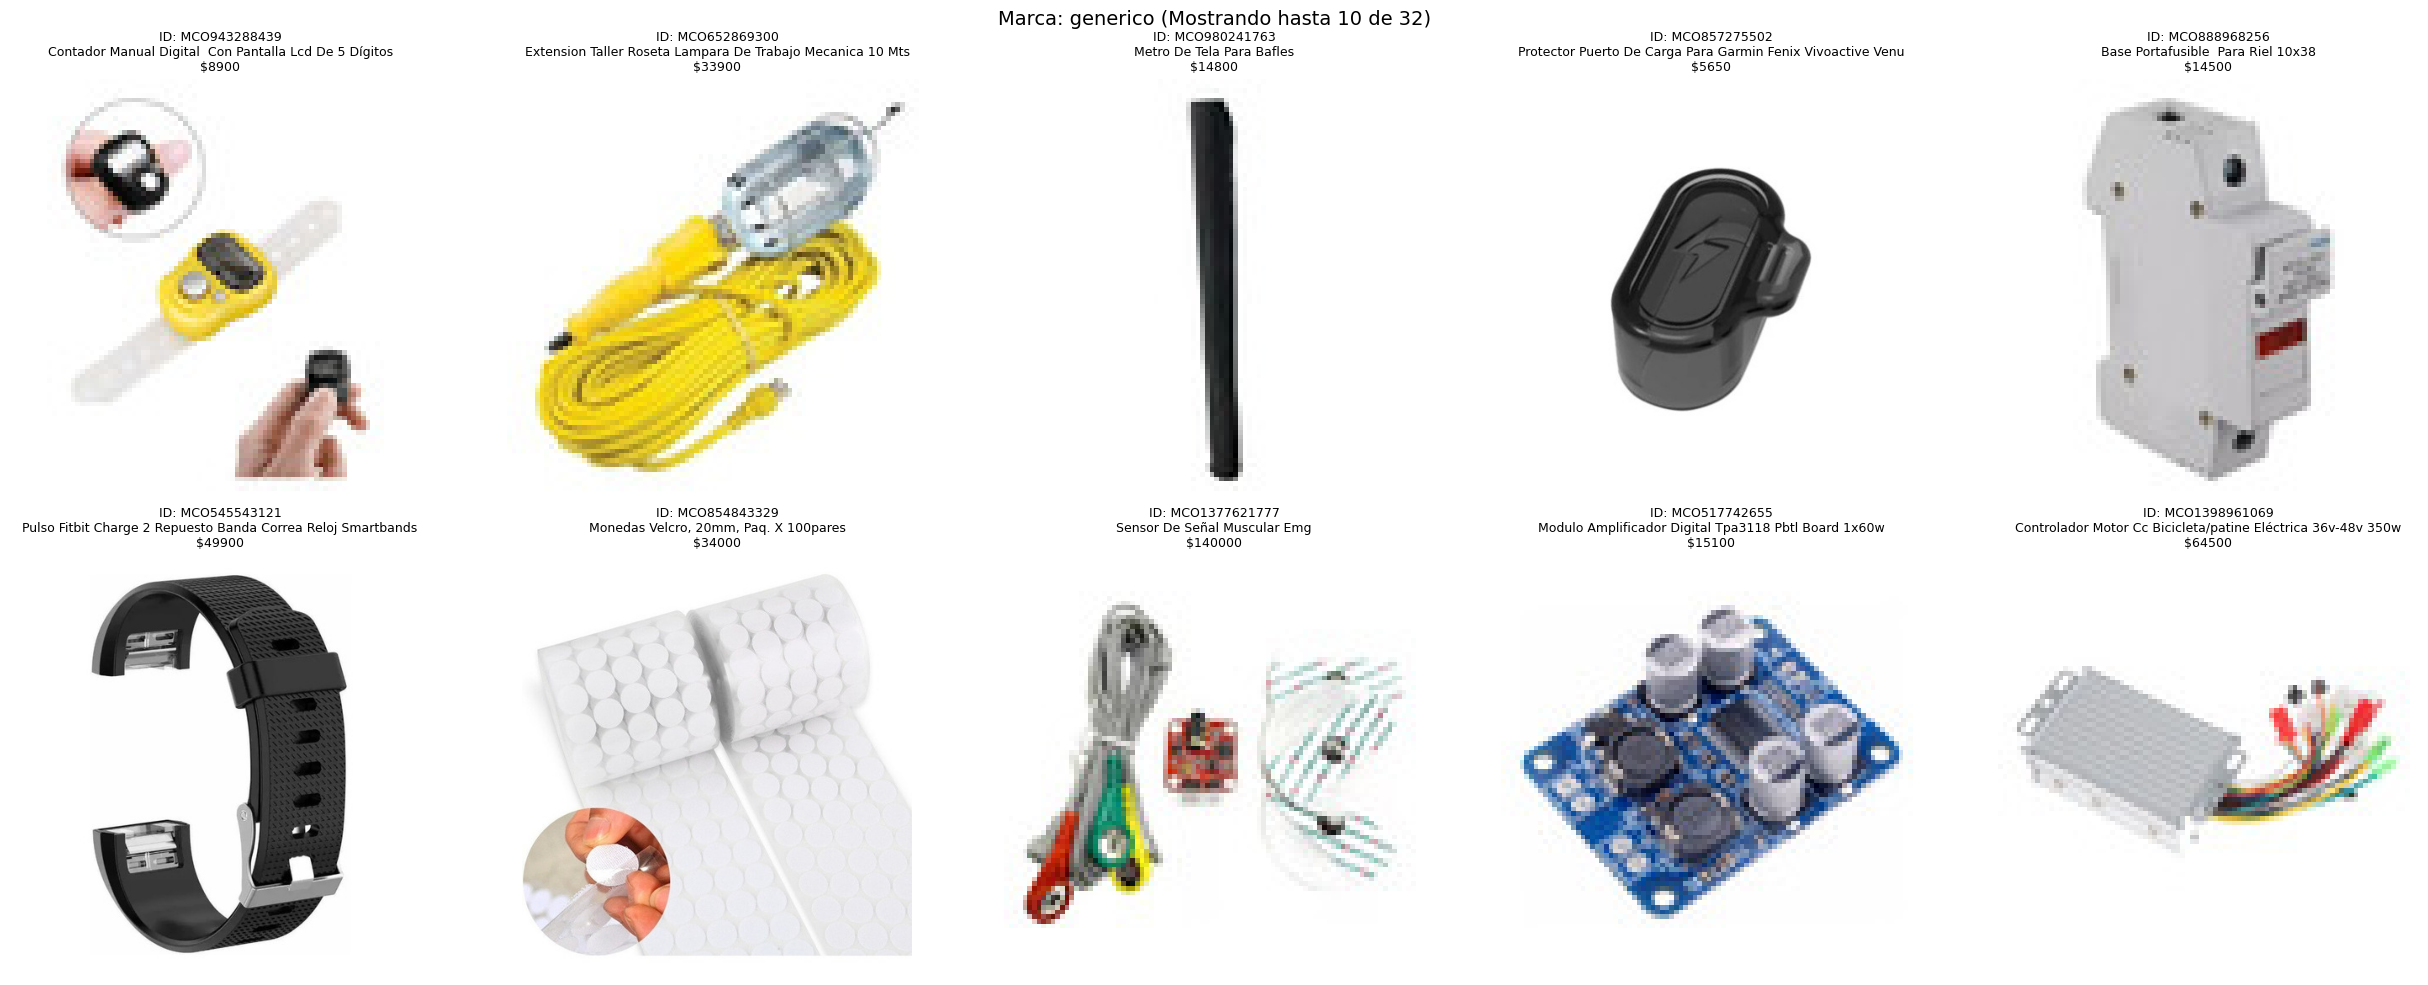


=== Marca: 'del agro soluciones' (Total productos: 29) ===


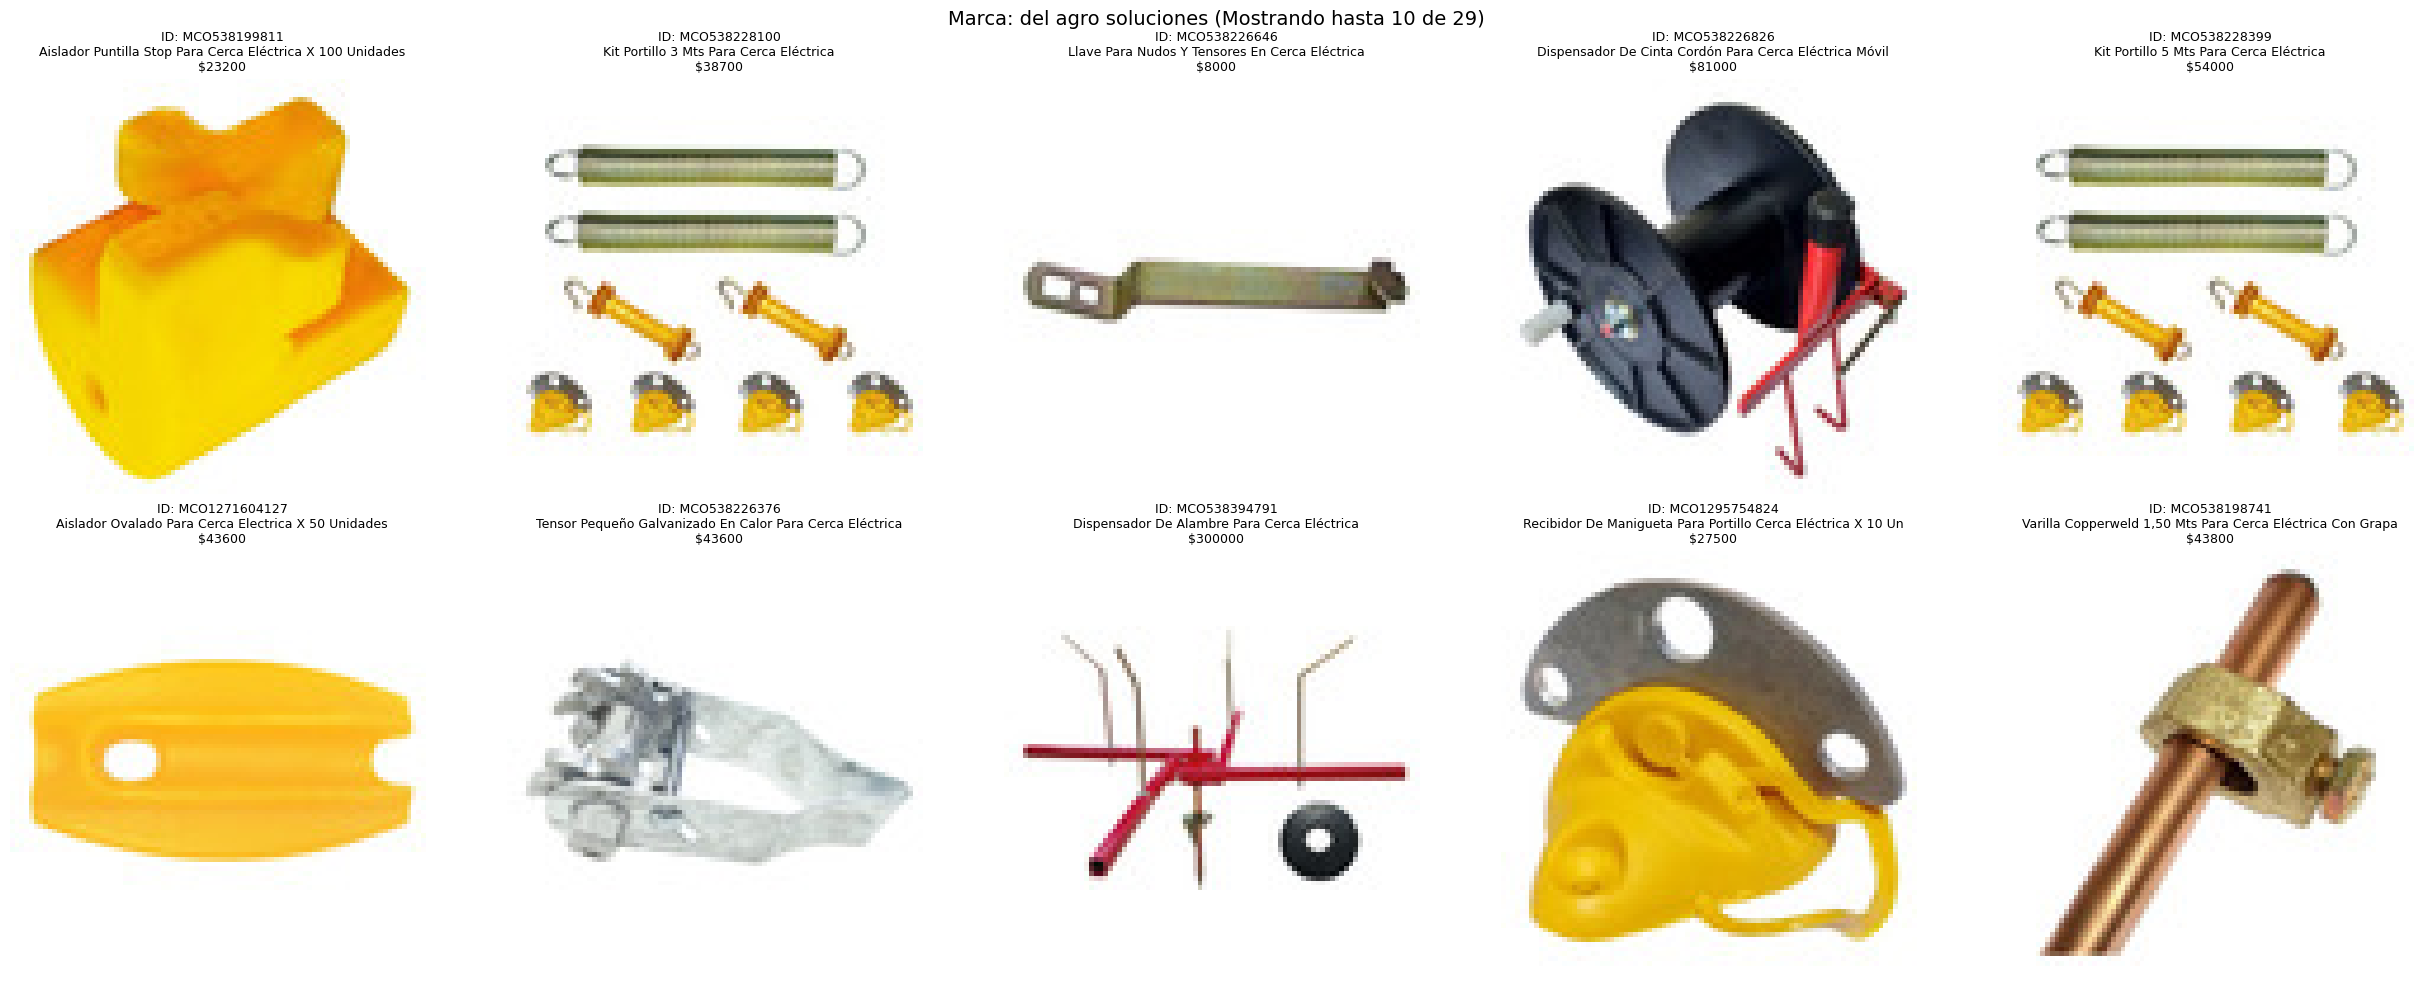

In [7]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import math

def download_image(url):
    """
    Descarga la imagen desde 'url' y retorna un objeto PIL Image o None si falla.
    """
    try:
        resp = requests.get(url, timeout=5)
        if resp.status_code == 200:
            return Image.open(BytesIO(resp.content))
    except:
        pass
    return None

# Contar productos por marca
brand_counts = df['brand_std'].value_counts().reset_index()
brand_counts.columns = ['brand_std', 'count']

# Seleccionar las 5 marcas con más productos
top_5_brands = brand_counts.head(5)

# Graficar productos asociados a las marcas seleccionadas
for i, row in top_5_brands.iterrows():
    brand_val = row['brand_std']
    total_count = row['count']
    
    print(f"\n=== Marca: '{brand_val}' (Total productos: {total_count}) ===")
    
    # Filtrar productos asociados a la marca actual
    group = df[df['brand_std'] == brand_val]
    
    # Limitar a un máximo de 10 productos por marca
    group = group.head(10)
    
    # Calcular filas y columnas dinámicamente
    max_cols = 5
    cols = min(len(group), max_cols)
    rows = math.ceil(len(group) / cols)
    
    # Crear figura y ajustar tamaño
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    if rows == 1 and cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    fig.suptitle(f"Marca: {brand_val} (Mostrando hasta 10 de {total_count})", fontsize=14)
    
    for j, (idx, product) in enumerate(group.iterrows()):
        ax = axes[j]
        thumbnail = product.get('thumbnail', None)
        product_id = product.get('id', 'N/A')
        price = product.get('price', '(sin precio)')
        title = product.get('title', '(sin título)')
        img = None
        
        if isinstance(thumbnail, str) and thumbnail.strip():
            img = download_image(thumbnail)
        
        if img:
            ax.imshow(img)
            ax.set_title(f"ID: {product_id}\n{title}\n${price}", fontsize=9)
        else:
            ax.text(0.5, 0.5, "No image", ha='center', va='center', fontsize=10)
            ax.set_title(f"ID: {product_id}\n{title}\n${price}", fontsize=9)
        
        ax.axis('off')
    
    # Desactivar subplots sobrantes si hay menos de rows*cols
    total_subplots = rows * cols
    if len(group) < total_subplots:
        for k in range(len(group), total_subplots):
            axes[k].axis('off')
    
    plt.tight_layout()
    plt.show()

# Limpieza y Estandarización de GTIN

## Remover caracteres irrelevantes
Elimina guiones, comas o espacios en el GTIN para dejar únicamente los dígitos, salvo que la API requiera un formato puntual.  
**Ejemplo:**  
“000-222312332” → “000222312332”.

## Dividir múltiplos
Si un ítem contiene varios códigos GTIN separados por comas, es recomendable separarlos y manejarlos individualmente, o bien escoger el más relevante.  
**Ejemplo:**  
“000222312332,00055398329” → [000222312332, 00055398329].

## Verificar longitud
Un GTIN válido generalmente tiene 8, 12, 13 o 14 dígitos. Si la longitud no coincide, verificar si es un error de captura.  
- Si es demasiado corto (por ejemplo, 5 dígitos), podría no ser un GTIN real.

## Eliminar duplicados
En algunos casos, un ítem puede reportar el mismo GTIN varias veces. Se debe conservar uno único para evitar confusiones en la comparación.


In [8]:
import pandas as pd
import re

def clean_gtin(gtin_value):
    """
    Procesa un string que puede contener uno o varios GTINs,
    separados por comas o con caracteres extra (guiones, espacios).
    
    Pasos:
      1. Separar por comas (si hay más de un GTIN en la misma celda).
      2. Remover caracteres no numéricos (excepto si se desea permitir algo).
      3. Validar longitud (8, 12, 13 o 14 dígitos). Si no coincide, se descarta.
      4. Eliminar duplicados dentro de la lista final.
      
    Retorna una lista de GTINs limpios (strings numéricos).
    """
    if pd.isnull(gtin_value):
        # Si es NaN o None, retornar lista vacía
        return []
    
    # Convertir a string por si viene como número o algo distinto
    gtin_str = str(gtin_value)
    
    # Separar por comas (si la celda tiene varios GTINs juntos, ej. "000222312332,00055398329")
    possible_codes = gtin_str.split(',')
    
    clean_codes = []
    for code in possible_codes:
        # Eliminar guiones, espacios y cualquier carácter no numérico
        # con una expresión regular que deje solo dígitos
        digits_only = re.sub(r'[^0-9]', '', code)
        
        # Validar longitud: 8, 12, 13 o 14
        if len(digits_only) in [8, 12, 13, 14]:
            clean_codes.append(digits_only)
    
    # Eliminar duplicados
    unique_codes = list(set(clean_codes))
    
    return unique_codes


df['gtin_std'] = df['gtin'].apply(clean_gtin)

# Ejemplo de impresión de resultados:
print(df[['gtin', 'gtin_std']].head(10))


                        gtin                      gtin_std
0  000223213232,000055393829  [000055393829, 000223213232]
1                        NaN                            []
2                        NaN                            []
3                        NaN                            []
4              7707314156920               [7707314156920]
5                        NaN                            []
6                        NaN                            []
7                        NaN                            []
8                        NaN                            []
9              7707314156920               [7707314156920]


In [12]:
gtin_counts = df['gtin_std'].value_counts().reset_index()
gtin_counts.columns = ['gtin_std', 'count']
gtin_counts

gtin_std  count
0                              []    677
1                 [7707314156920]    184
2                [01234567812342]     12
3                 [7707314157583]     11
4                 [7630049200050]      7
..                            ...    ...
94  [0762931887869, 762931887869]      1
95                [5060515860174]      1
96  [086000272593, 0012306024109]      1
97  [0672205002204, 672205002204]      1
98  [605930132700, 0605930132700]      1

[99 rows x 2 columns]


=== GTIN '7707314156920' (Total productos: 184) ===


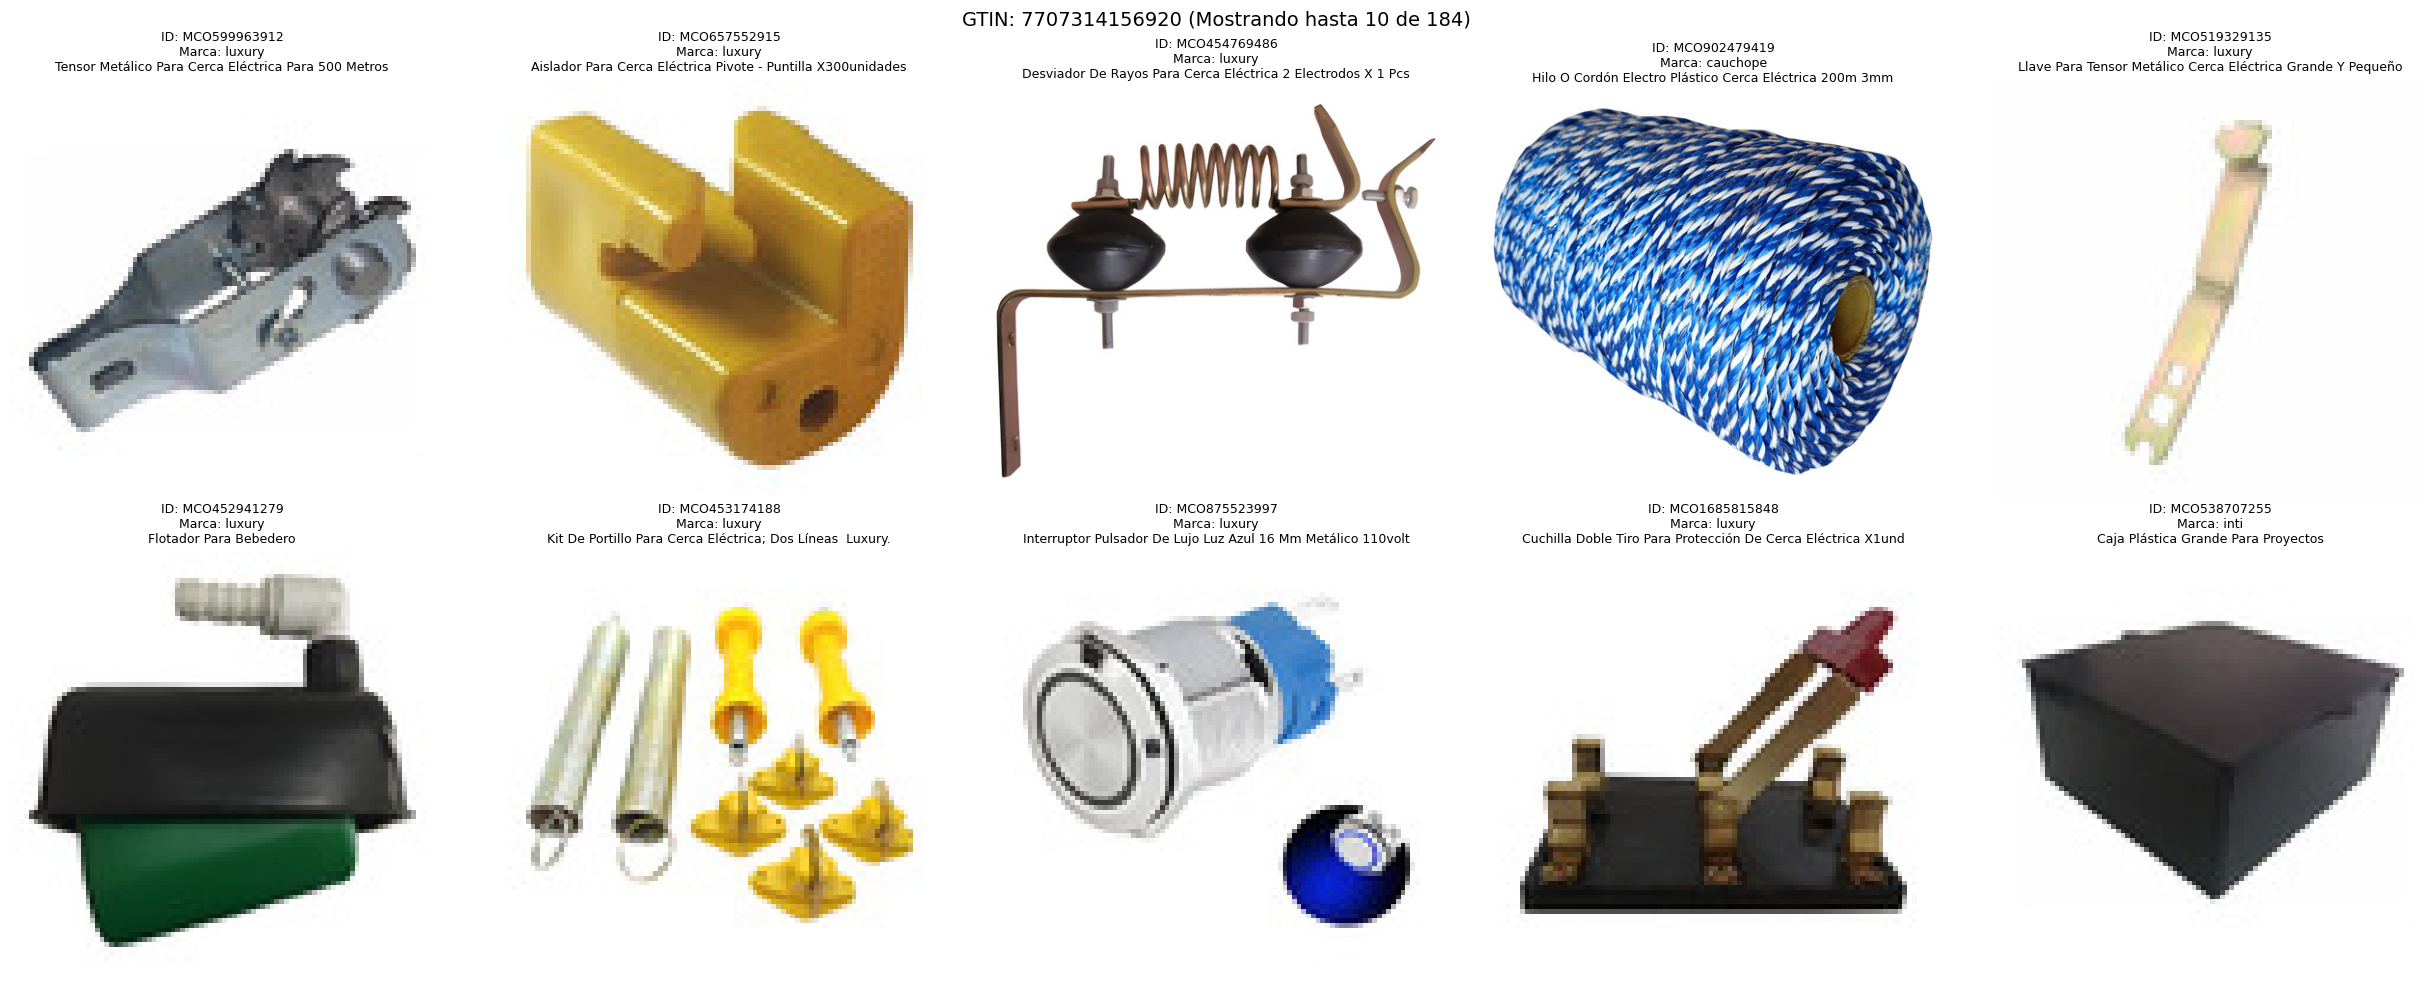


=== GTIN '01234567812342' (Total productos: 12) ===


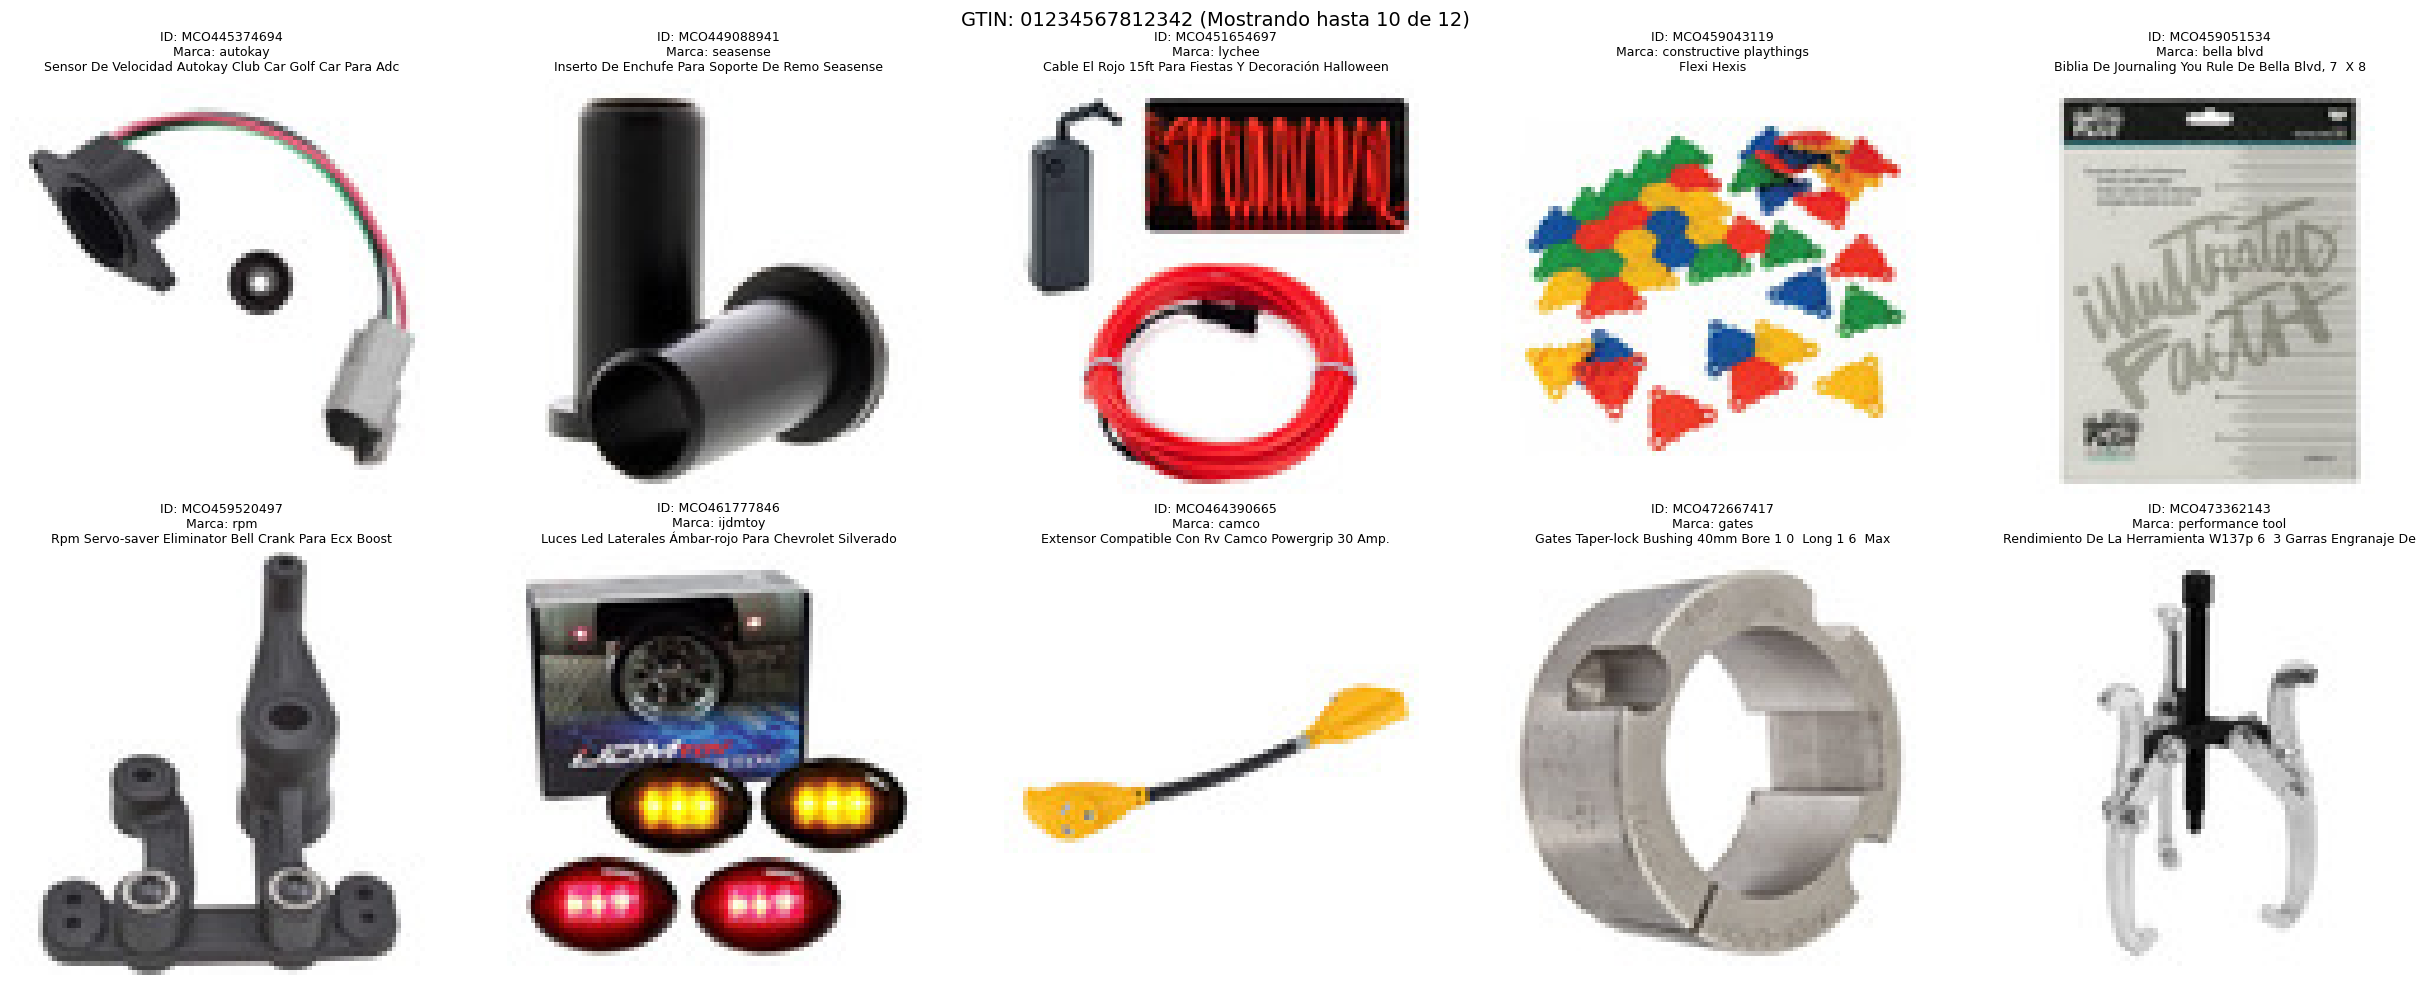


=== GTIN '7707314157583' (Total productos: 11) ===


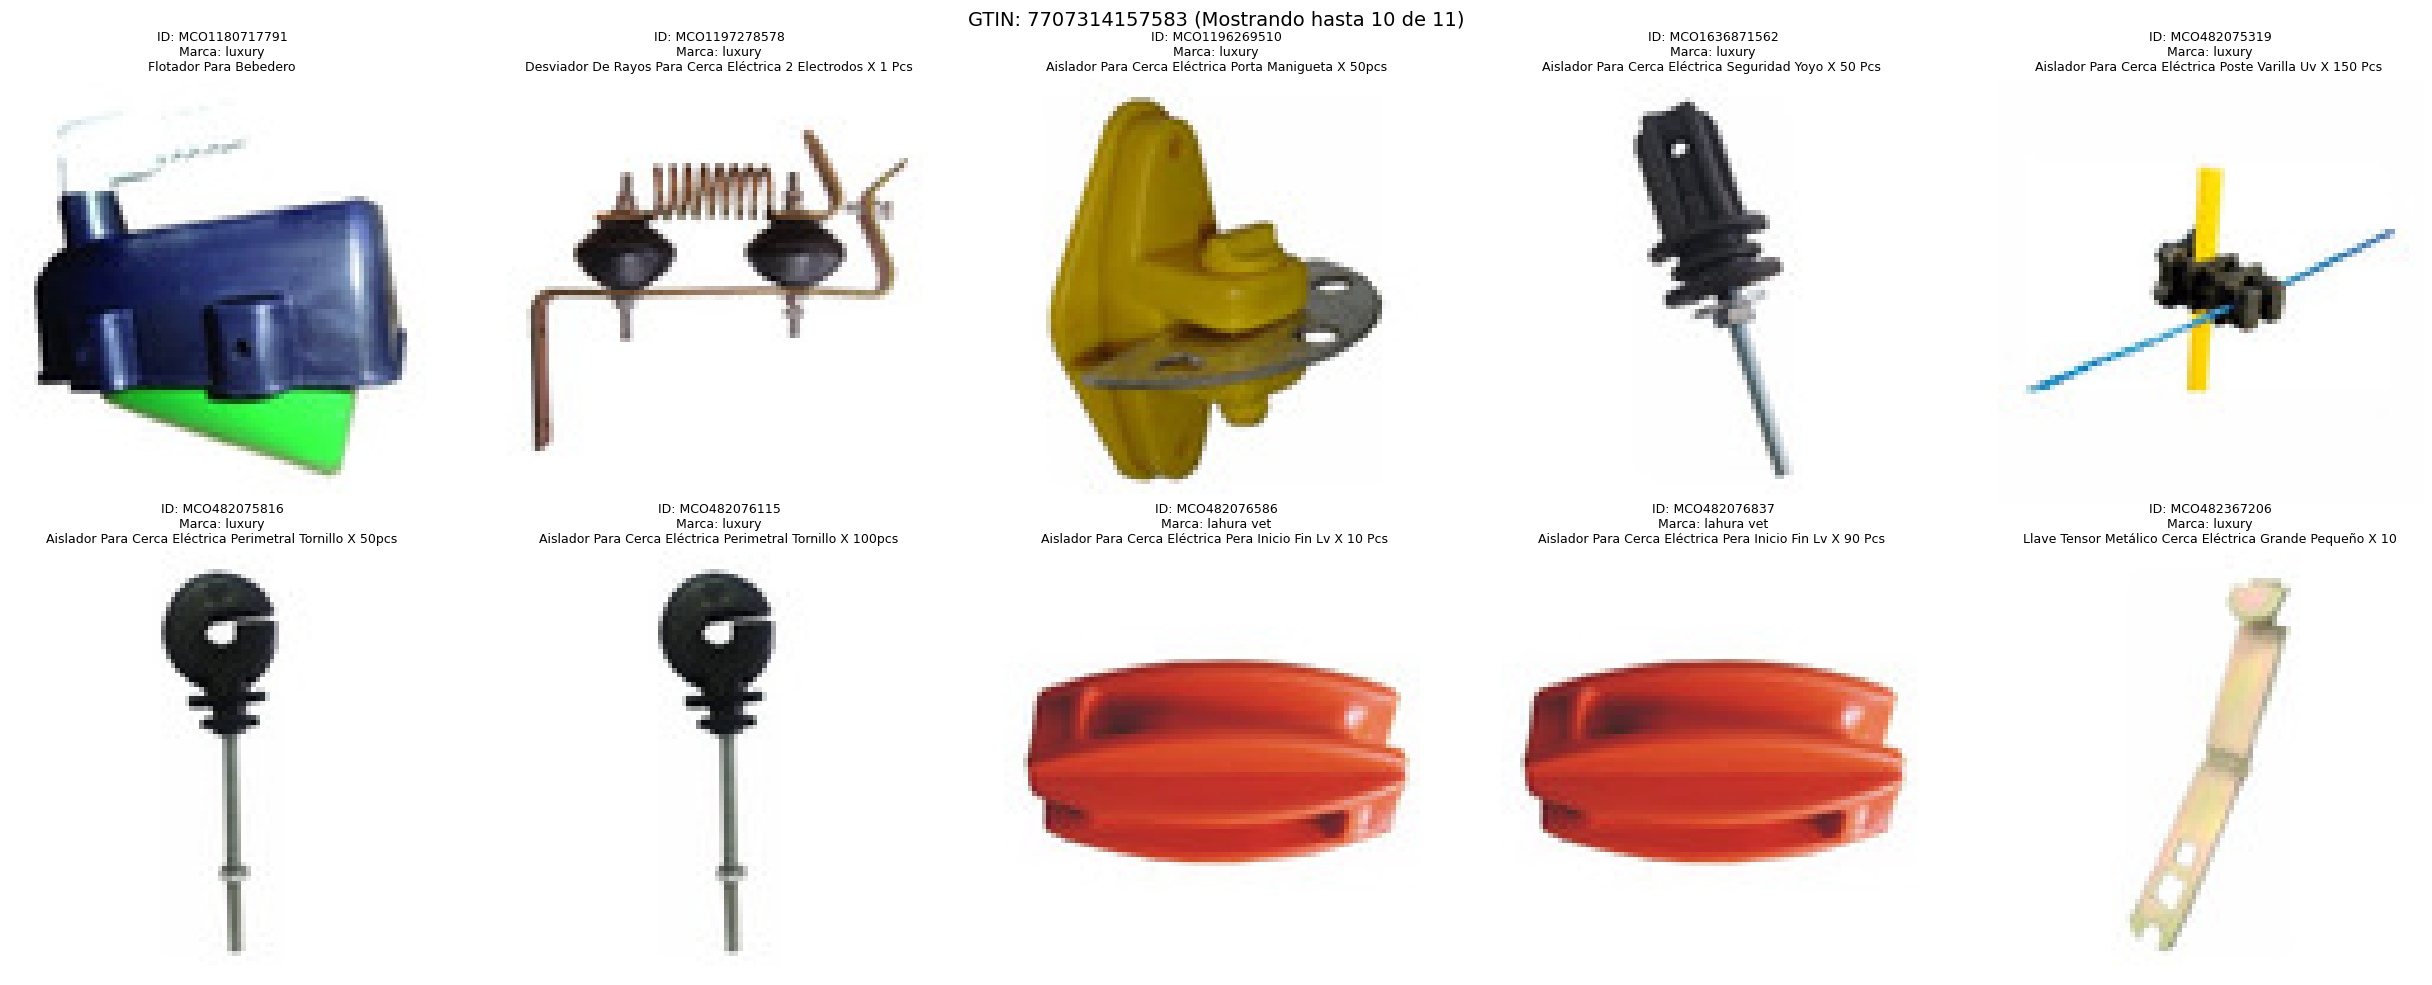


=== GTIN '7630049200050' (Total productos: 7) ===


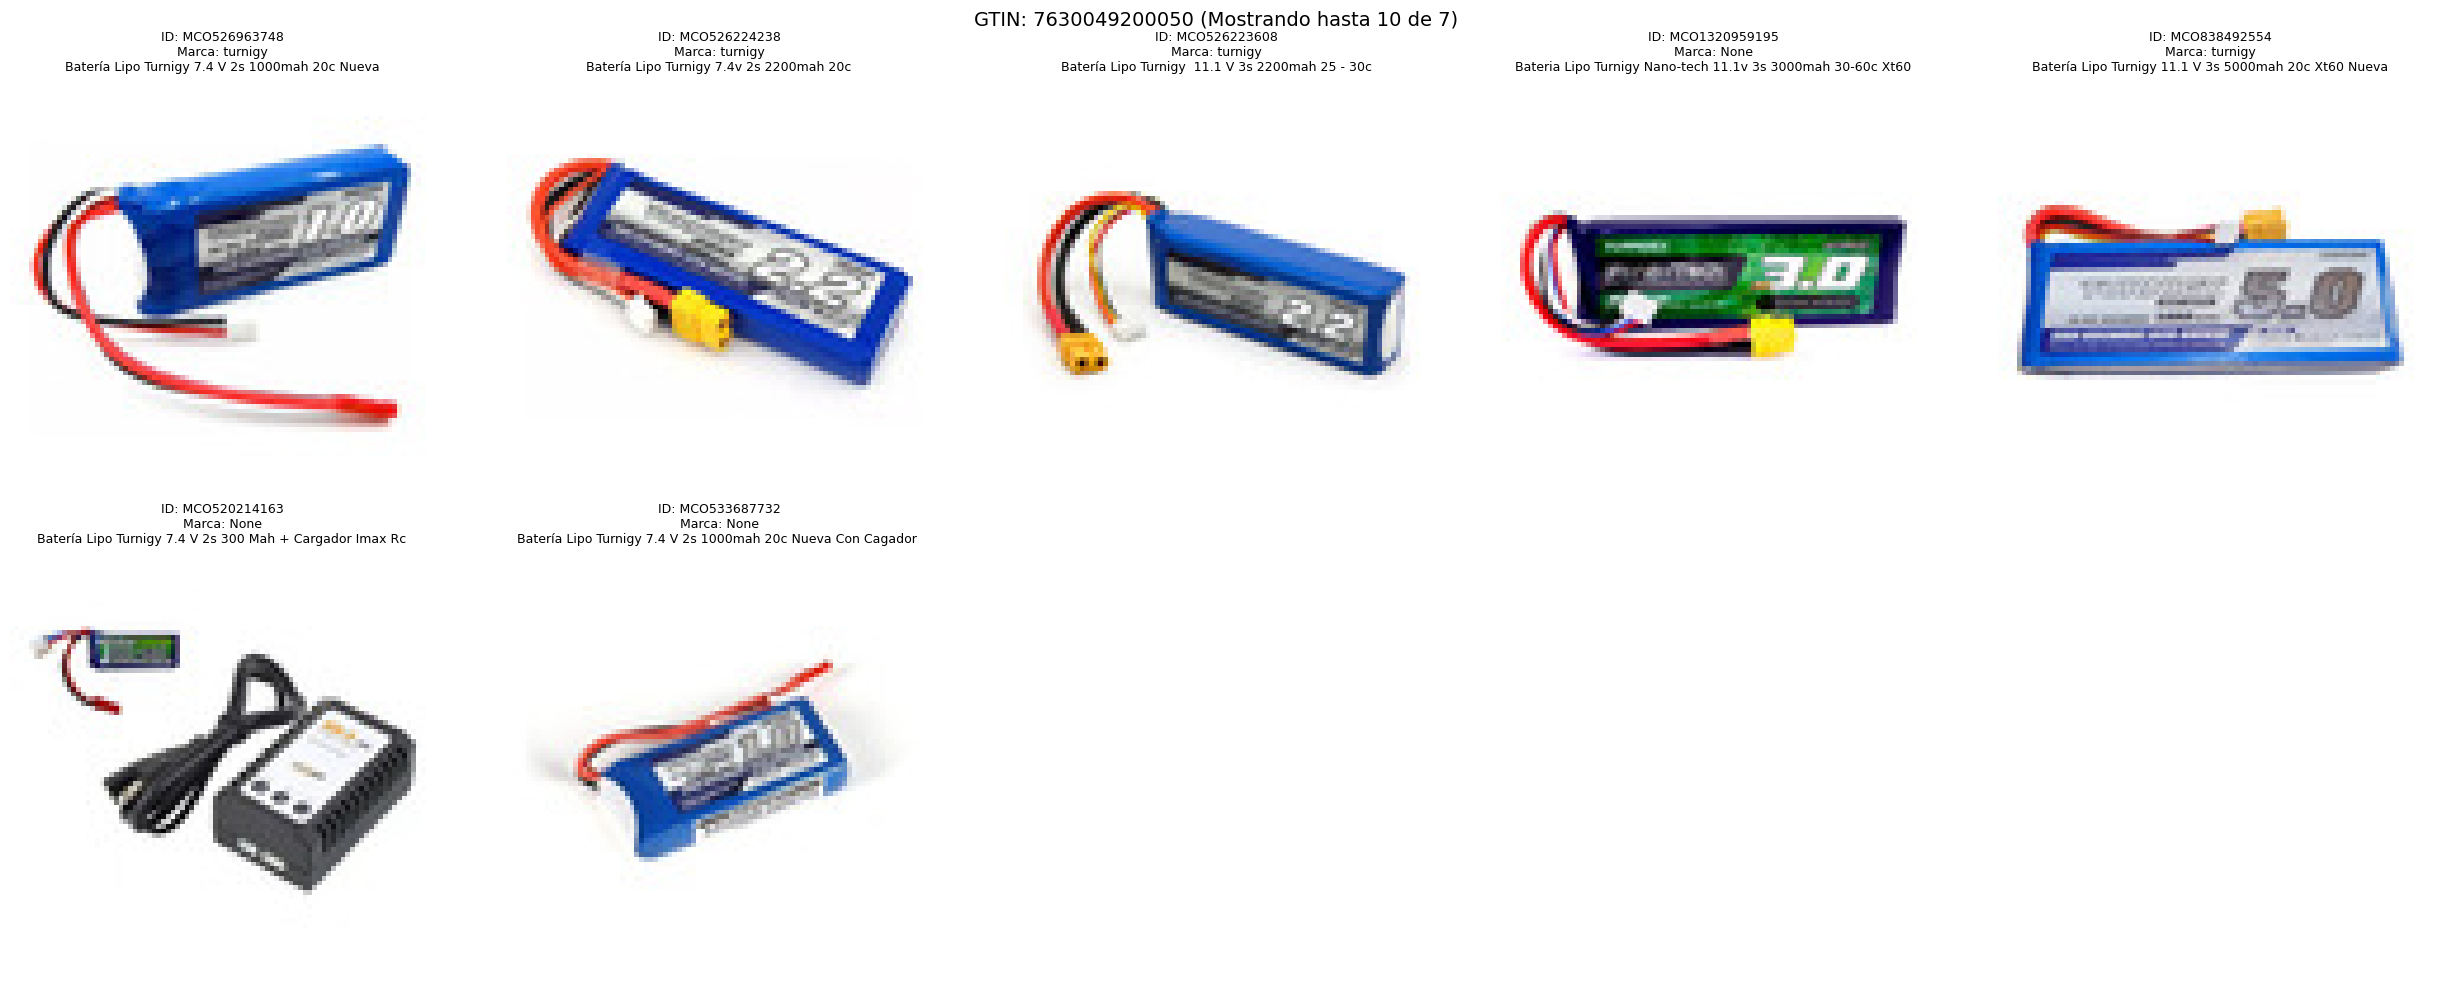


=== GTIN '7707297410736' (Total productos: 5) ===


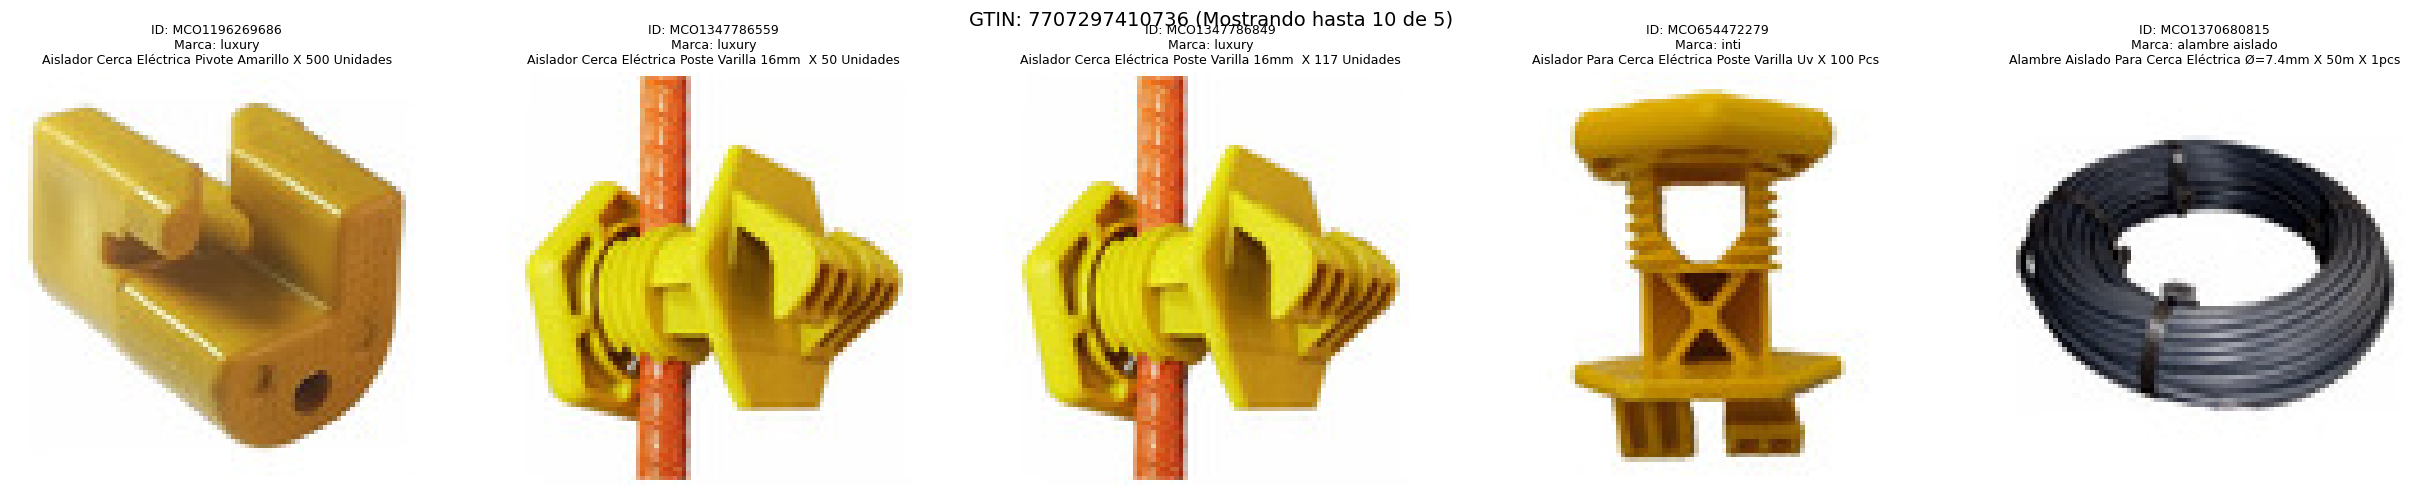

In [35]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import math

def download_image(url):
    """
    Descarga la imagen y retorna un objeto PIL Image o None si falla.
    """
    try:
        resp = requests.get(url, timeout=5)
        if resp.status_code == 200:
            return Image.open(BytesIO(resp.content))
    except:
        pass
    return None

# Suponiendo que df['gtin_std'] ha sido 'explode' si era lista
df_ex = df.explode('gtin_std').dropna(subset=['gtin_std'])

# Contar los productos por GTIN
gtin_counts = df_ex['gtin_std'].value_counts().reset_index()
gtin_counts.columns = ['gtin_std', 'count']

# Seleccionar los 5 GTINs más repetidos
top_5_gtins = gtin_counts.head(5)

# Graficar productos asociados a los GTINs seleccionados
for i, row in top_5_gtins.iterrows():
    gtin_val = row['gtin_std']
    total_count = row['count']
    
    print(f"\n=== GTIN '{gtin_val}' (Total productos: {total_count}) ===")
    
    # Filtrar productos asociados al GTIN actual
    group = df_ex[df_ex['gtin_std'] == gtin_val]
    
    # Limitar a 10 productos para mostrar
    group = group.head(10)
    
    # Calcular dinámicamente filas y columnas
    max_cols = 5
    cols = min(len(group), max_cols)
    rows = math.ceil(len(group) / cols)
    
    # Crear figura y ajustar tamaño
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    if rows == 1 and cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    fig.suptitle(f"GTIN: {gtin_val} (Mostrando hasta 10 de {total_count})", fontsize=14)
    
    for j, (idx, product) in enumerate(group.iterrows()):
        ax = axes[j]
        thumbnail = product.get('thumbnail', None)
        brand = product.get('brand_std', 'desconocido')
        title = product.get('title', '(sin título)')
        product_id = product.get('id', 'N/A')
        img = None
        
        if isinstance(thumbnail, str) and thumbnail.strip():
            img = download_image(thumbnail)
        
        if img:
            ax.imshow(img)
            ax.set_title(f"ID: {product_id}\nMarca: {brand}\n{title}", fontsize=9)
        else:
            ax.text(0.5, 0.5, "No image", ha='center', va='center', fontsize=10)
            ax.set_title(f"ID: {product_id}\nMarca: {brand}\n{title}", fontsize=9)
        
        ax.axis('off')
    
    # Desactivar subplots sobrantes si hay menos de rows*cols
    total_subplots = rows * cols
    if len(group) < total_subplots:
        for k in range(len(group), total_subplots):
            axes[k].axis('off')
    
    plt.tight_layout()
    plt.show()



# Limpieza y Estandarización de Title (Título)

## Conversión a minúsculas (o mayúsculas) uniformes
Convierte todos los títulos a un formato uniforme, ya sea en minúsculas o mayúsculas.  
**Ejemplo:**  
“Limpiador Electrónico – Removedor De Polvo” → “limpiador electrónico – removedor de polvo”.

## Eliminación de caracteres no alfanuméricos
Remueve símbolos irrelevantes como “-”, “/”, “()”, “...” o reemplázalos por espacios para preservar información semántica.

## Remoción de stopwords o palabras redundantes
Elimina palabras que no aportan al significado, como “el”, “la”, “para”, “con”.  
**Nota:** En ciertos contextos, podría preferirse conservarlas según la estrategia de embeddings utilizada.

## Normalización de sinónimos
Unifica términos técnicos o equivalentes para consistencia.  
**Ejemplo:**  
“tv”, “televisor”, “televisión” → “tv” o “televisor” (dependiendo del contexto).


In [9]:
import re
import pandas as pd
import spacy

# Cargar el modelo de spaCy en español
nlp = spacy.load("es_core_news_sm")

# Lista de stopwords ejemplo en español (puede ampliarse)
stopwords_es = {
    "el", "la", "los", "las", "para", "con", "de", "del", "y", "o", "a", "que", "en", "un", "una"
}

# Diccionario de sinónimos o equivalencias
synonyms_dict = {
    "televisor": "tv",
    "television": "tv",
    "tv": "tv",
    "televisión": "tv",
}

def normalize_synonyms(token):
    """
    Dado un token, revisa si está en el diccionario de sinónimos 
    y devuelve la forma estandarizada.
    """
    if token in synonyms_dict:
        return synonyms_dict[token]
    return token

def clean_title(title, remove_stopwords=True, do_lemmatize=False):
    """
    Limpia y estandariza un título:
      1) Convierte a minúsculas
      2) Elimina caracteres no alfanuméricos (sustituidos por espacio)
      3) Tokeniza por espacios
      4) (Opcional) Remueve stopwords
      5) Aplica sinónimos
      6) (Opcional) Lematiza (requiere spaCy en español)
      7) Reconstruye el título limpio
    """
    if not isinstance(title, str):
        return ""
    
    # 1) Convertir a minúsculas
    title = title.lower()
    
    # 2) Eliminar caracteres no alfanuméricos (excepto, p. ej., tildes y espacios)
    #    Conviértelos en espacio para no pegar palabras
    title = re.sub(r"[^a-z0-9áéíóúñü]+", " ", title)
    
    # 3) Tokenizar por espacios
    tokens = title.split()
    
    # 4) Remover stopwords (opcional)
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stopwords_es]
    
    # 5) Aplicar sinónimos
    tokens = [normalize_synonyms(t) for t in tokens]
    
    # 6) Lematizar con spaCy (opcional)
    #    Asegúrate de haber cargado el modelo nlp = spacy.load("es_core_news_sm")
    if do_lemmatize and len(tokens) > 0:
        doc = nlp(" ".join(tokens))
        tokens = [token.lemma_ for token in doc]
    
    # 7) Reconstruir
    cleaned_title = " ".join(tokens)
    
    return cleaned_title

# ===========================
# EJEMPLO DE USO
# ===========================
# Supongamos que df['title'] existe:
df['title_std'] = df['title'].apply(clean_title)
# 
# O para incluir lematización:
df['title_std_lemma'] = df['title'].apply(lambda x: clean_title(x, do_lemmatize=True))
#
# Ver los primeros ejemplos
print(df[['title', 'title_std', 'title_std_lemma']].head(10))


                                               title  \
0                     Cerca 75km - Ganado - Impulsor   
1      Planta Cerca Electrica Para Ganado 50km M. Jr   
2  Limpiador  Electrónico -removedor De Polvo - A...   
3  Planta Cerca Eléctrica Solar 100km, Incluye Pa...   
4  Tensor Metálico Para Cerca Eléctrica Para 500 ...   
5  Termohigrometro Htc-2 Con Certificado De Calib...   
6     Temporizador Timer Digital Mini Modelo Tue-11    
7  Aislador Para Cerca Eléctrica Tipo Pivote-punt...   
8  Aislador Para Cerca Eléctrica Poste Varilla Uv...   
9  Aislador Para Cerca Eléctrica Pivote - Puntill...   

                                           title_std  \
0                         cerca 75km ganado impulsor   
1            planta cerca electrica ganado 50km m jr   
2  limpiador electrónico removedor polvo aire com...   
3  planta cerca eléctrica solar 100km incluye pan...   
4         tensor metálico cerca eléctrica 500 metros   
5      termohigrometro htc 2 certificado calibr

In [12]:
title_counts = df['title_std_lemma'].value_counts().reset_index()
title_counts.columns = ['title_std_lemma', 'count']
title_counts

title_std_lemma  count
0        temporizador timer digital mini modelo tue 11      4
1    interruptor pulsador lujo luz rojo 16 mm metál...      3
2    aislador cerca eléctrico poste varilla uv x 15...      3
3    cinto electro plástico cerca eléctrico 12 mm 2...      3
4    helar cordón electro plástico cerca eléctrico ...      3
..                                                 ...    ...
951  gripple plus medium pack 20 alambre joiner tensor      1
952  presurizador bomba automatico soluciona bajo p...      1
953  8 5 x 11 sostenedor mostrar acrílico transparente      1
954  fantasia walt disney video laserdisc musical e...      1
955  bomba agua 12v bomba agua sumergible magnética...      1

[956 rows x 2 columns]


=== Título: 'temporizador timer digital mini modelo tue 11' (Cantidad: 4) ===


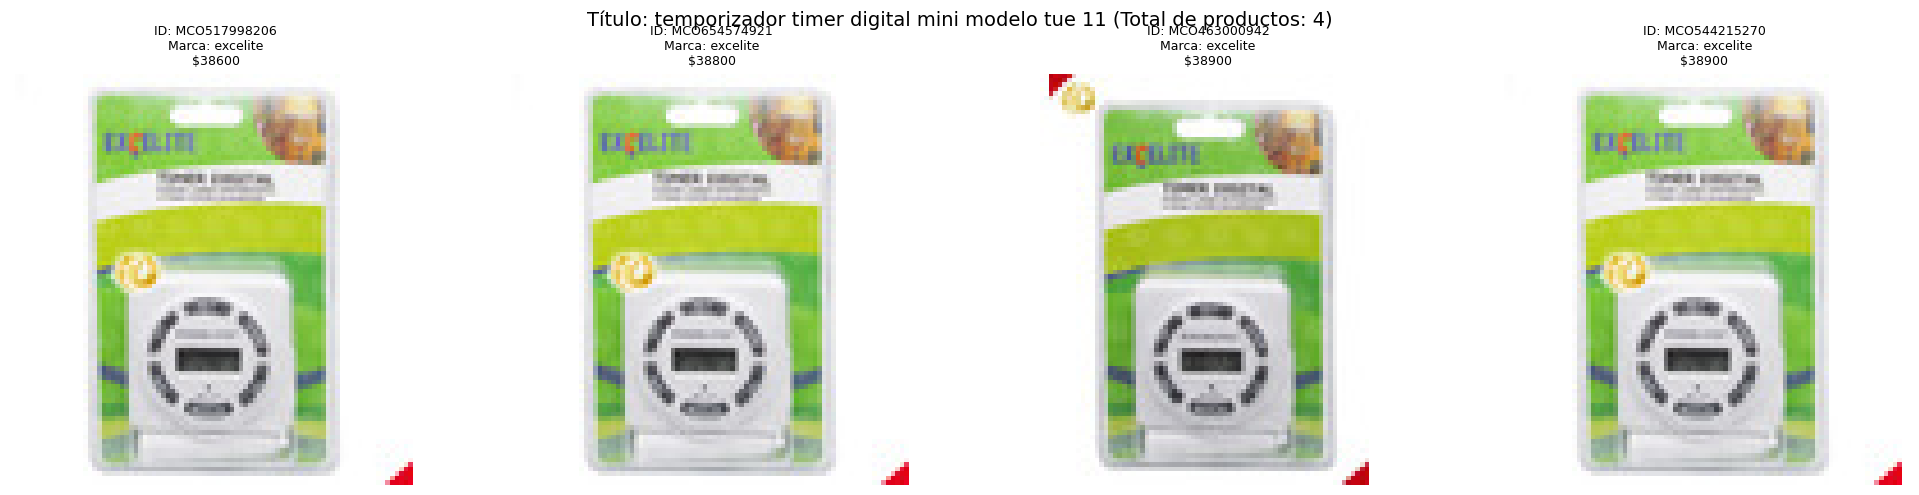


=== Título: 'interruptor pulsador lujo luz rojo 16mm metálico 110vac' (Cantidad: 3) ===


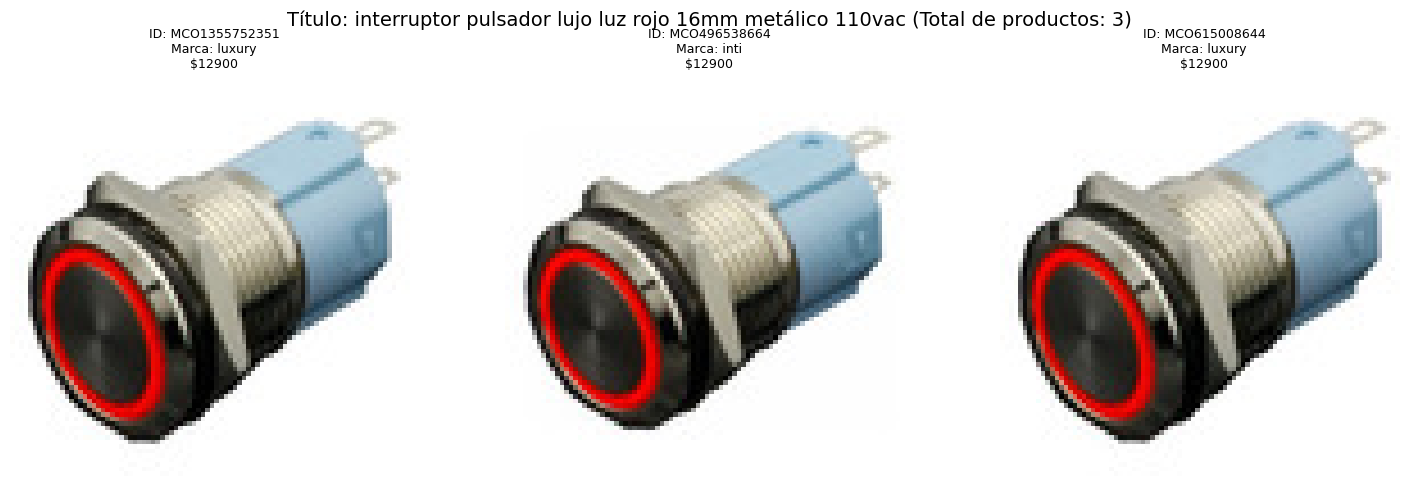


=== Título: 'aislador cerca eléctrica poste varilla uv x 150 pcs' (Cantidad: 3) ===


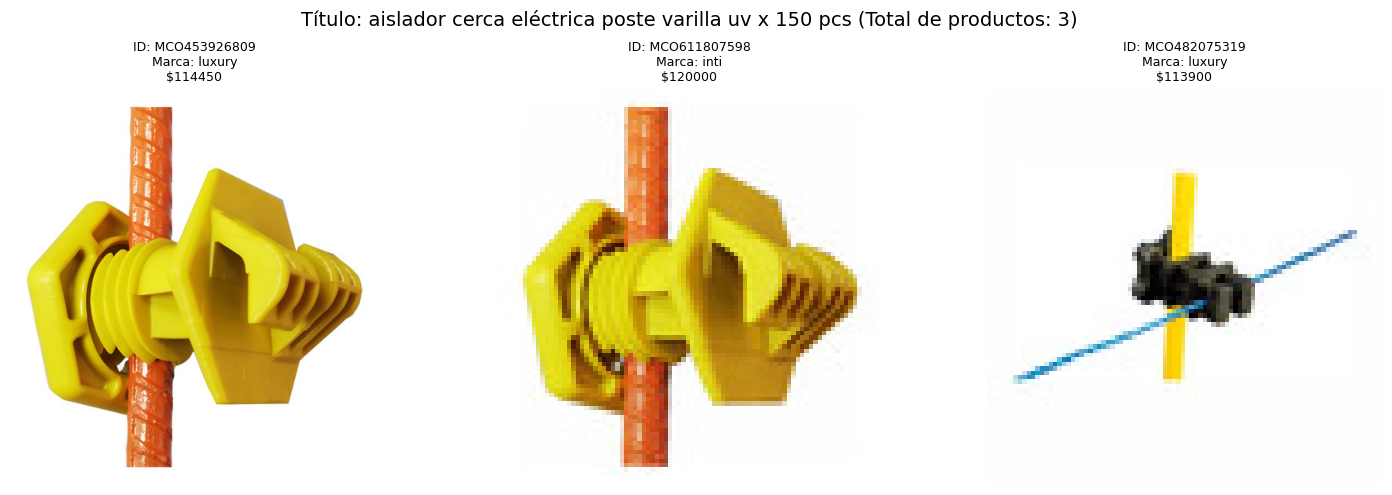


=== Título: 'cinta electro plástica cerca eléctrica 12mm 200mts' (Cantidad: 3) ===


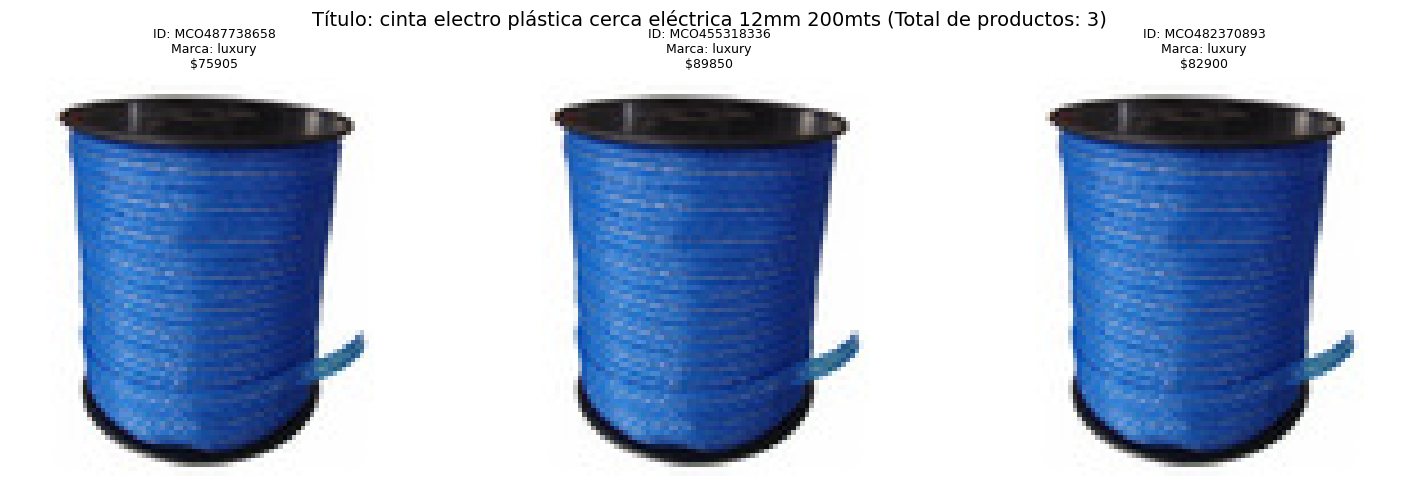


=== Título: 'hilo cordón electro plástico cerca eléctrica 200m 3mm' (Cantidad: 3) ===


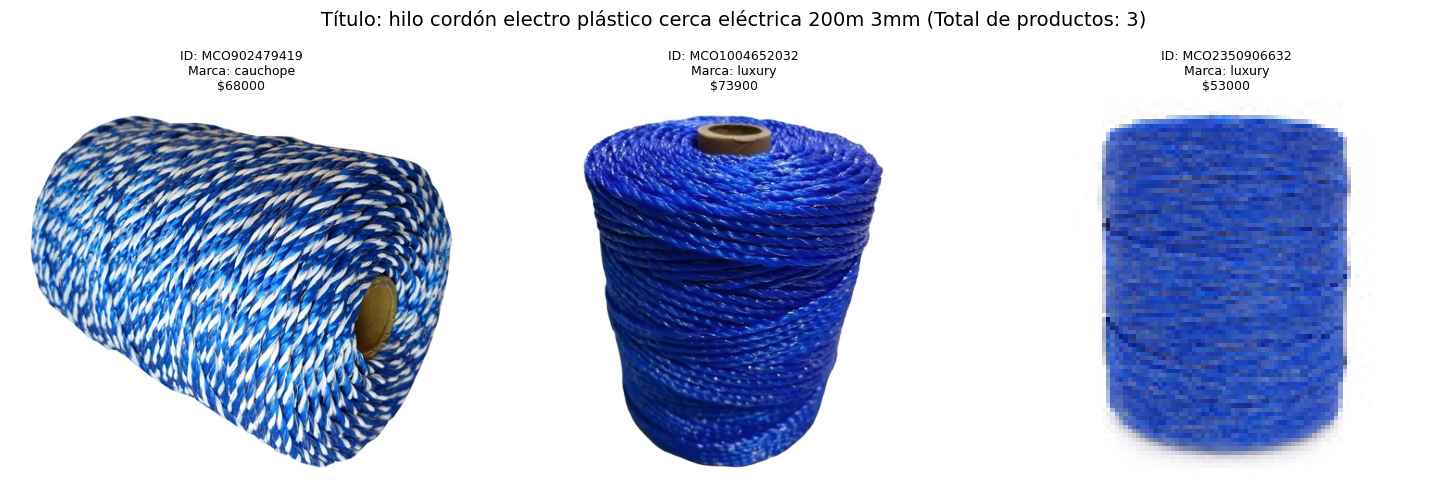

In [13]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import math

def download_image(url):
    """
    Descarga la imagen desde 'url' y retorna un objeto PIL Image o None si falla.
    """
    try:
        resp = requests.get(url, timeout=5)
        if resp.status_code == 200:
            return Image.open(BytesIO(resp.content))
    except:
        pass
    return None

# Contar la cantidad de productos por título
title_counts = df['title_std'].value_counts().reset_index()
title_counts.columns = ['title_std', 'count']

# Seleccionar los 5 títulos más repetidos
top_5_titles = title_counts.head(5)

# Graficar los productos asociados a cada título
for i, row in top_5_titles.iterrows():
    title_val = row['title_std']
    count = row['count']
    
    print(f"\n=== Título: '{title_val}' (Cantidad: {count}) ===")
    
    # Filtrar productos asociados al título actual
    group = df[df['title_std'] == title_val]
    
    # Calcular filas y columnas para subplots
    max_cols = 5
    cols = min(len(group), max_cols)
    rows = math.ceil(len(group) / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    if rows == 1 and cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    fig.suptitle(f"Título: {title_val} (Total de productos: {count})", fontsize=14)
    
    for j, (idx, product) in enumerate(group.iterrows()):
        ax = axes[j]
        thumbnail = product.get('thumbnail', None)
        brand = product.get('brand_std', 'desconocido')
        product_id = product.get('id', 'N/A')
        price = product.get('price', '(sin precio)')
        img = None
        
        if isinstance(thumbnail, str) and thumbnail.strip():
            img = download_image(thumbnail)
        
        if img:
            ax.imshow(img)
            ax.set_title(f"ID: {product_id}\nMarca: {brand}\n${price}", fontsize=9)
        else:
            ax.text(0.5, 0.5, "No image", ha='center', va='center', fontsize=10)
            ax.set_title(f"ID: {product_id}\nMarca: {brand}\n${price}", fontsize=9)
        
        ax.axis('off')
    
    # Desactivar subplots sobrantes si hay menos de rows*cols
    total_subplots = rows * cols
    if len(group) < total_subplots:
        for k in range(len(group), total_subplots):
            axes[k].axis('off')
    
    plt.tight_layout()
    plt.show()


Price# Limpieza y Estandarización de Precios

## Conversión a string
Convierte los valores a cadenas para facilitar la manipulación.  
Esto permite manejar datos numéricos o cadenas que representen precios.

## Eliminación de símbolos de moneda
Remueve símbolos comunes de moneda como `$`, `COP`, `USD`, `COL$`, etc., para normalizar los valores.  
**Ejemplo:**  
`"$150.000 COP"` → `"150.000"`.

## Eliminación de separadores de miles
Quita separadores de miles como `.` o `,`, pero preserva el decimal (si lo hay).  
**Ejemplo:**  
`"1,250.50"` → `"1250.50"`.

## Normalización de formatos decimales
Si el formato decimal usa coma en lugar de punto, reemplázalo por punto para estandarizar.  
**Ejemplo:**  
`"1.250,50"` → `"1250.50"`.

## Conversión a float
Convierte los valores limpios a tipo `float` para un manejo más práctico.  
**Ejemplo:**  
`"1250.50"` → `1250.50`.

## Manejo de valores no válidos
Filtra valores no válidos, como:
- Precios negativos (`-150`).
- Valores fuera de rango razonable (opcional, como `1,000,000,000`).
- Valores no numéricos o vacíos.

## Aplicación al DataFrame
Aplica esta limpieza a la columna de precios en el DataFrame para obtener una columna estándar (`price_std`) lista para análisis.  
**Ejemplo de resultado:**  
| `price`            | `price_std` |
|---------------------|-------------|
| `$150.000 COP`      | `150000.0`  |
| `USD 1,250.50`      | `1250.5`    |
| `-50`               | `None`      |
| `COP$ 210`          | `210.0`     |



In [14]:
import pandas as pd
import re

def clean_price(price_value):
    """
    Limpia y estandariza valores de precio:
      1) Convierte a string para manipular
      2) Remueve símbolos de moneda (ej. '$', 'COP', etc.)
      3) Elimina separadores de miles (ej. '.', ',')
      4) Convierte a float (o int)
      5) Maneja casos no válidos (negativos, NaN)
    Retorna un float o None si no es posible parsear.
    """
    if pd.isnull(price_value):
        return None
    
    # Convertir a string
    price_str = str(price_value).strip()
    
    # 1) Remover símbolos de moneda y palabras comunes: '$', 'cop', 'usd', etc.
    #    Opcionalmente, se puede hacer un re.sub más amplio para otras monedas.
    price_str = re.sub(r'(\$|cop|usd|col\$)', '', price_str, flags=re.IGNORECASE)
    
    # 2) Eliminar separadores de miles (., ) excepto el punto decimal
    #    Una forma sencilla: remover TODOS los signos de puntuación salvo el punto final
    #    Nota: Esto asume que el decimal usa punto ('.')
    #    Si el decimal usa coma, habría que adaptarlo.
    #    Ejemplo: "1,250.50" -> "1250.50"
    
    # Primero, quitar espacios y otras cosas no numéricas (salvo punto y coma)
    # quedando solo dígitos, puntos y comas
    temp_str = re.sub(r'[^0-9.,-]+', '', price_str)
    
    # Si se usa coma como decimal, podrías reemplazarla por punto:
    # Pero esto depende del formato habitual de tus datos.
    # Por ejemplo: temp_str = temp_str.replace(',', '.')
    
    # En muchos casos, se ven separadores de miles como "." o ","
    # Se puede remover todas las comas y puntos salvo la última ocurrencia en la cadena
    # que se asume el decimal. Para simplificar, detectamos la parte decimal con una regex:
    
    # Dividir en parte entera y parte decimal (si existe)
    match = re.match(r'^([-]?\d+(?:[.,]\d+)?)(?:[.,](\d+))?$', temp_str)
    if not match:
        # Si no hay match, probar eliminar todas las comas/puntos y parsear
        # (caso "1.250" sin decimales)
        temp_str = re.sub(r'[.,]', '', temp_str)
    else:
        # match.group(1) es la parte entera o entera con decimal
        # match.group(2) es la parte decimal adicional
        pass
    
    # 3) Ahora quitar comas/puntos sobrantes
    no_punct_str = re.sub(r'[.,]', '', temp_str)
    
    # 4) Convertir a float
    try:
        value = float(no_punct_str)
    except ValueError:
        return None
    
    # 5) Manejo de valores negativos o no razonables
    if value < 0:
        return None
    
    # (Opcional) Aplicar un umbral máximo si se desea filtrar outliers
    # if value > 1_000_000_000:  # Ejemplo de outlier extremo
    #     return None
    
    return value

# ===========================
# EJEMPLO DE USO
# ===========================
# Supongamos que df['price'] contiene datos como "COP$ 150.000", "$210", "1,250.50usd", etc.
df['price_std'] = df['price'].apply(clean_price)

# Revisar resultados
print(df[['price', 'price_std']].head(15))


     price  price_std
0   165000   165000.0
1   140000   140000.0
2    21500    21500.0
3   690000   690000.0
4     6600     6600.0
5   115920   115920.0
6    38600    38600.0
7    19000    19000.0
8    41000    41000.0
9    50400    50400.0
10   23500    23500.0
11   68000    68000.0
12   36550    36550.0
13   46610    46610.0
14  101650   101650.0


In [15]:
price_counts = df['price_std'].value_counts().reset_index()
price_counts.columns = ['price_std', 'count']
price_counts

price_std  count
0      35000.0     12
1      29900.0      7
2      12900.0      7
3      15000.0      7
4      79900.0      6
..         ...    ...
646   259900.0      1
647   885000.0      1
648   274000.0      1
649   379999.0      1
650    11500.0      1

[651 rows x 2 columns]


=== Precio: 35000.0 (Cantidad: 12.0) ===


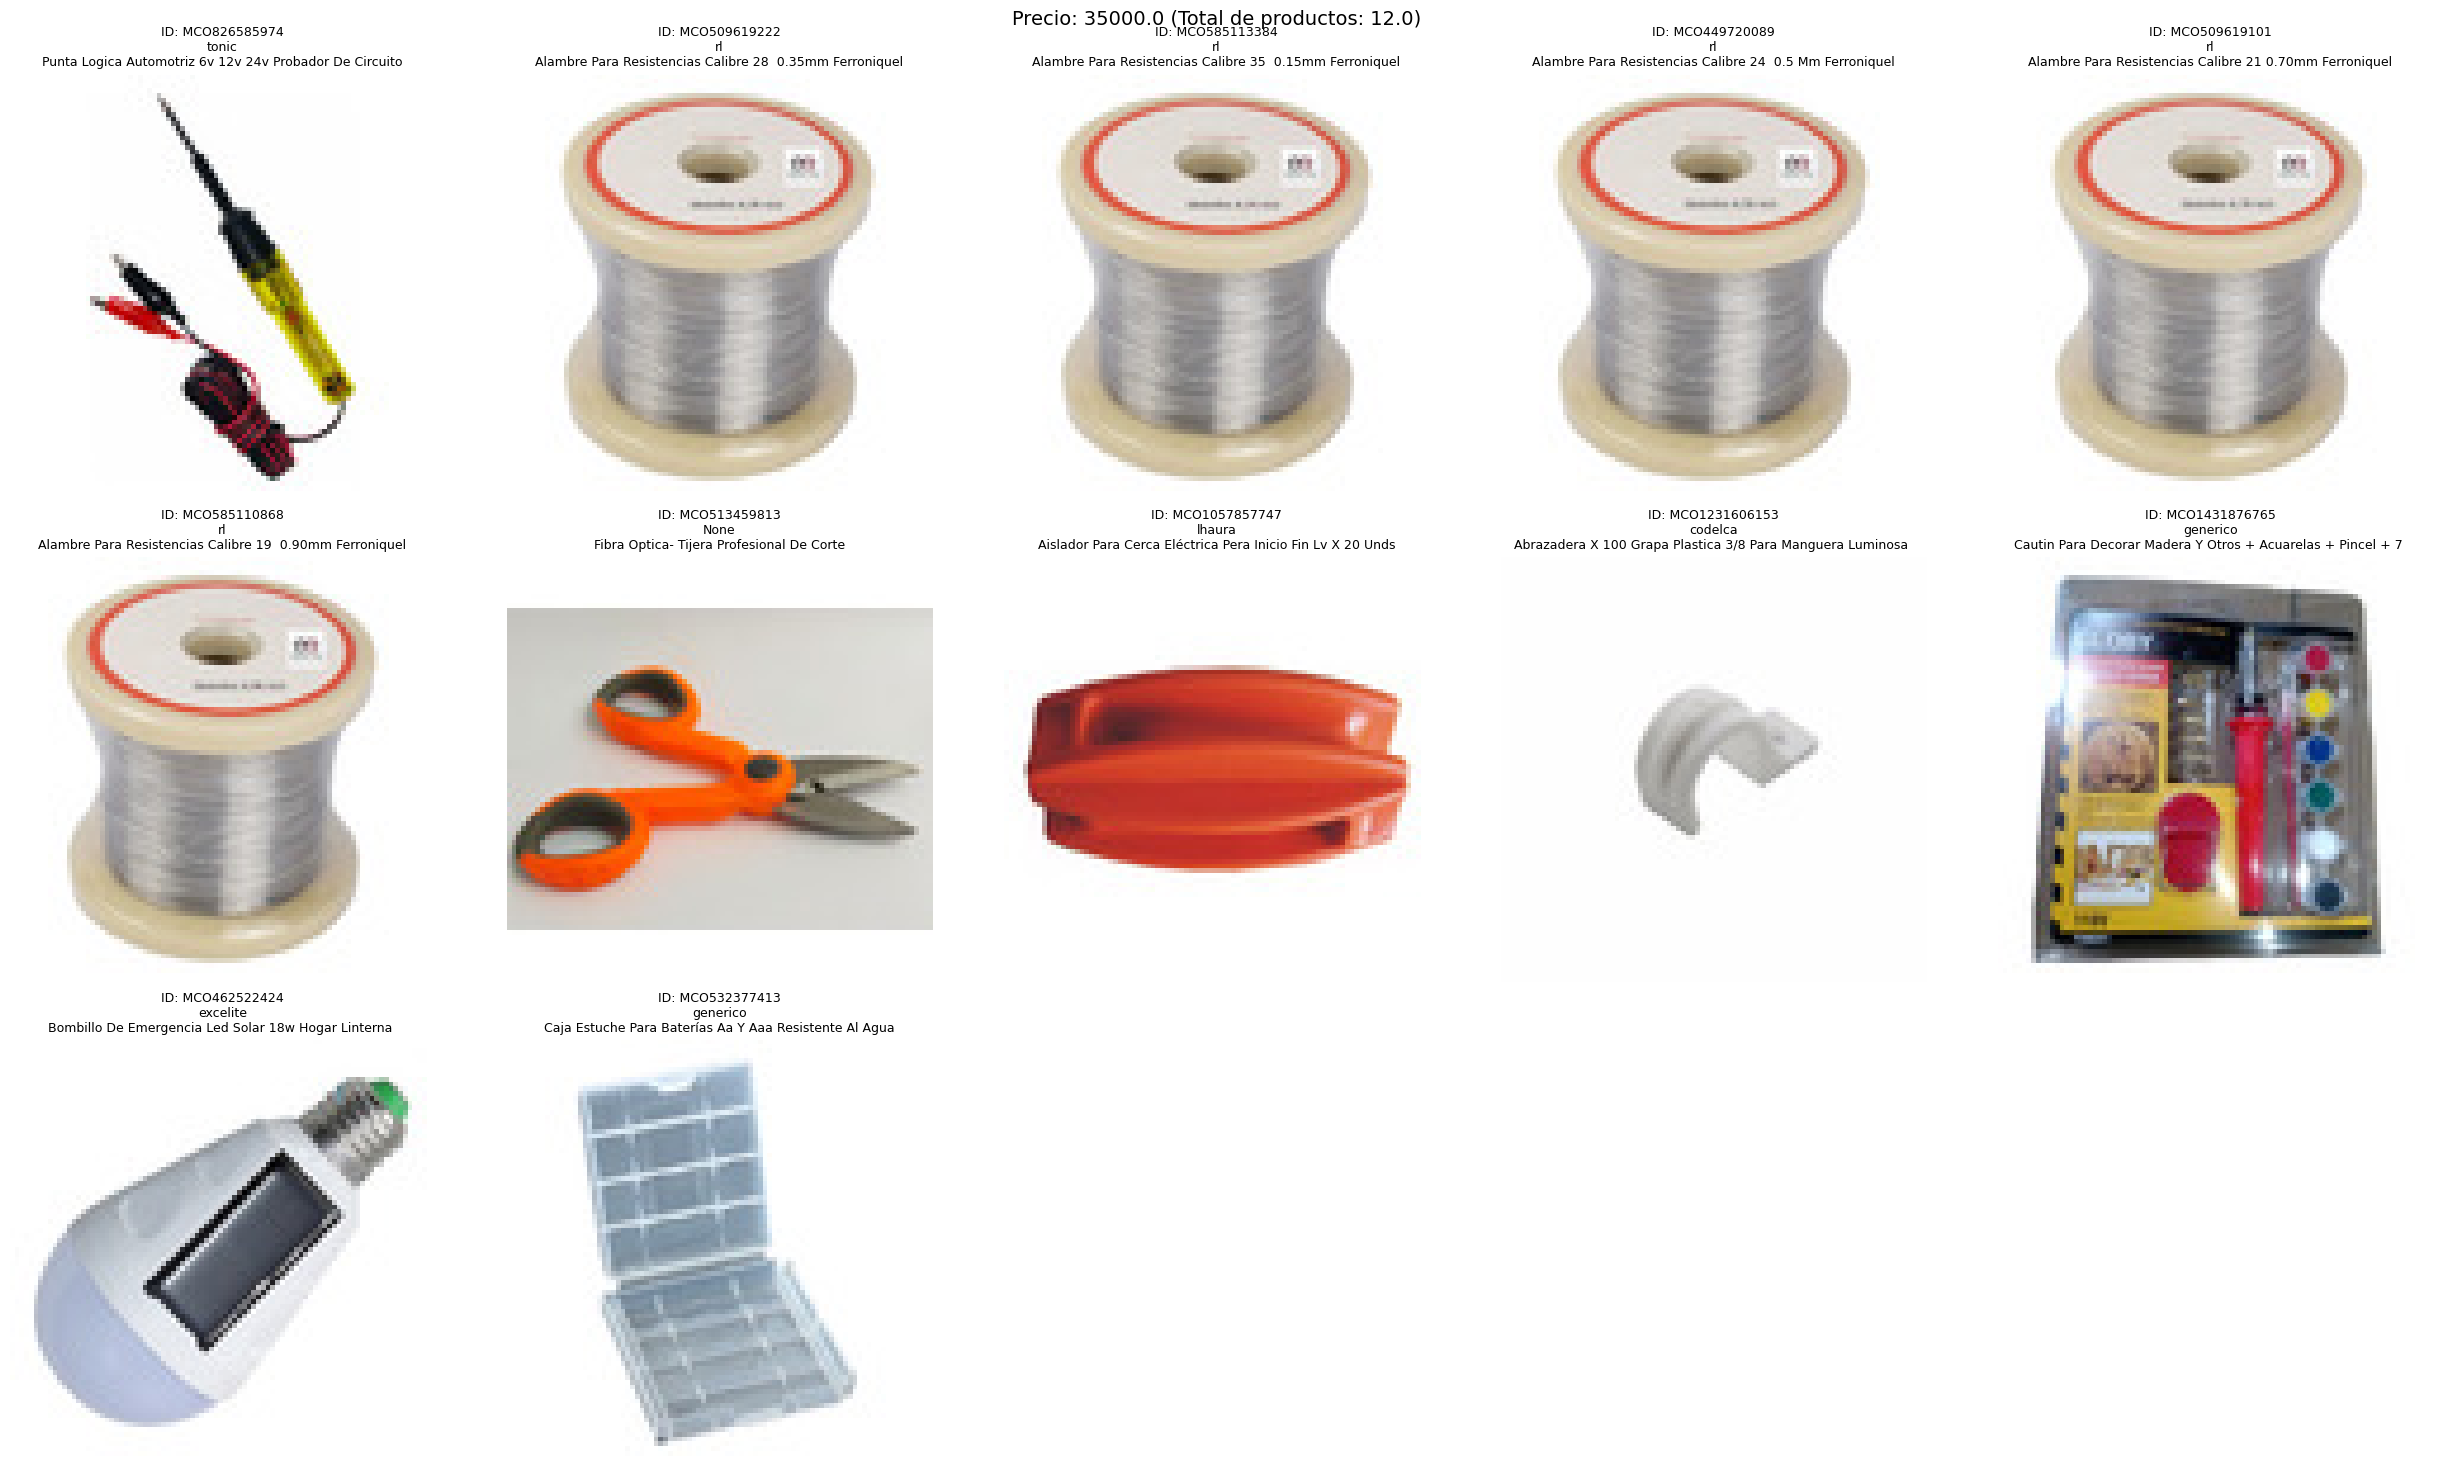


=== Precio: 29900.0 (Cantidad: 7.0) ===


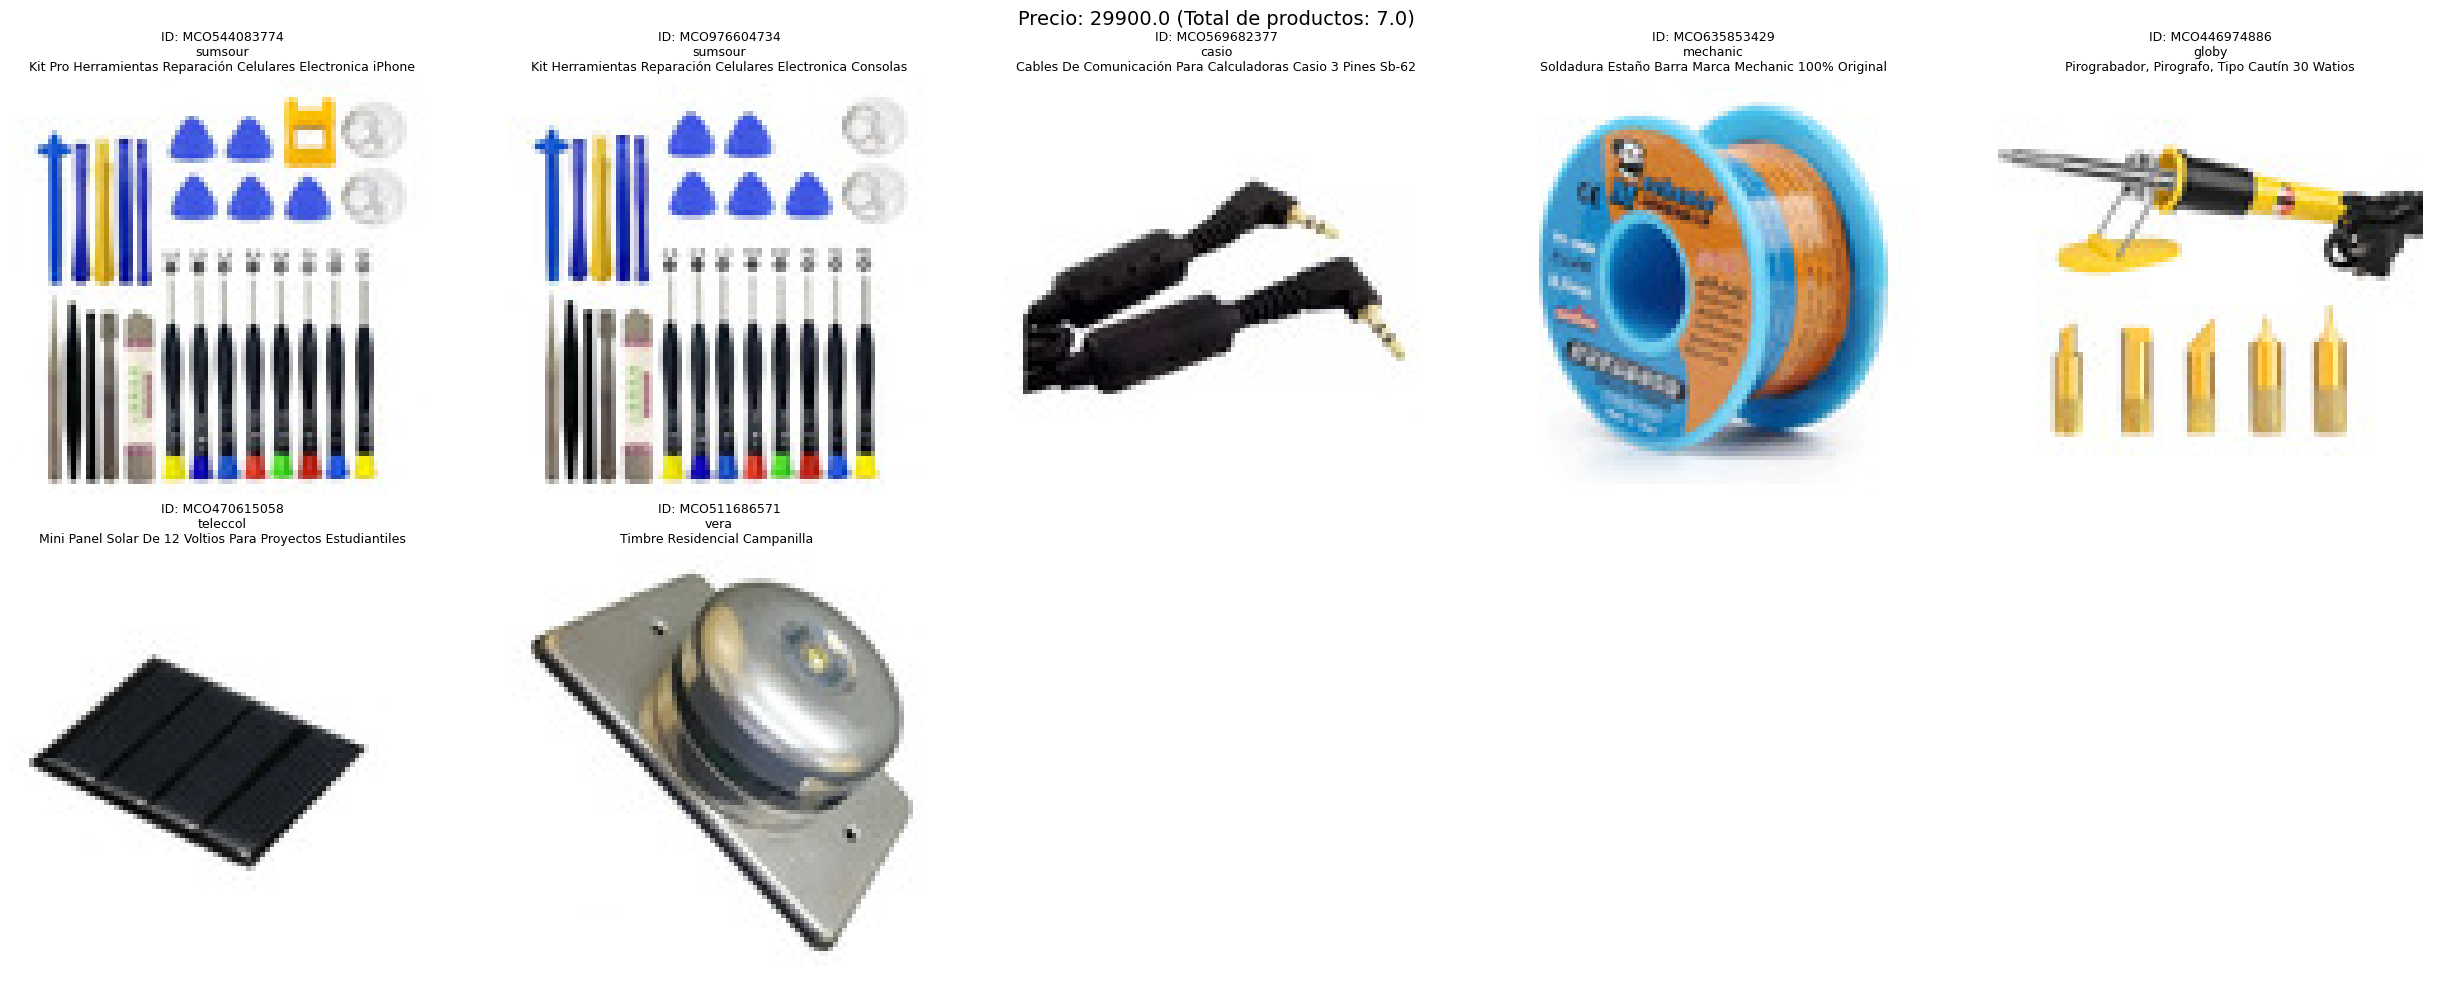


=== Precio: 12900.0 (Cantidad: 7.0) ===


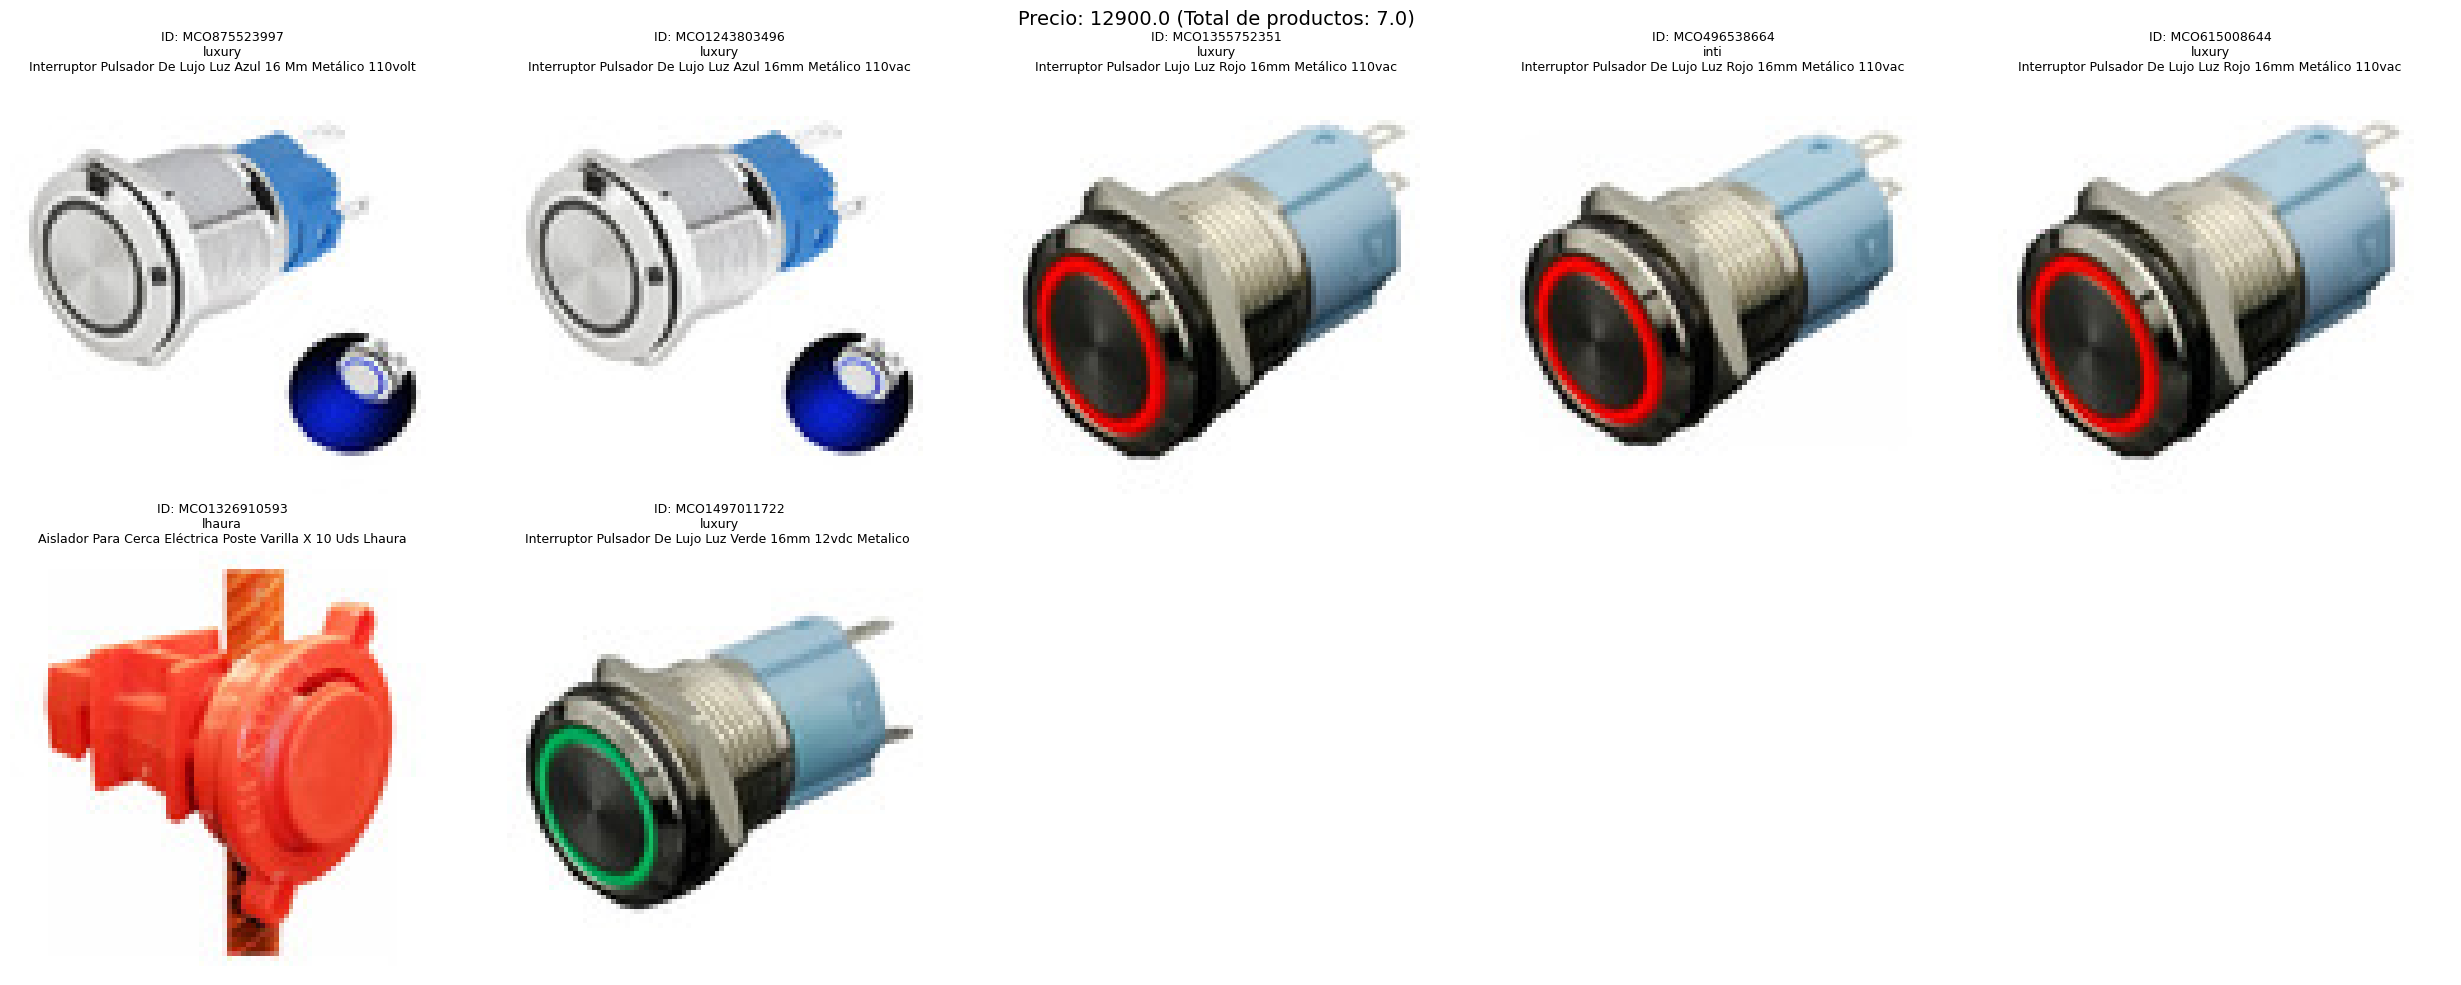


=== Precio: 15000.0 (Cantidad: 7.0) ===


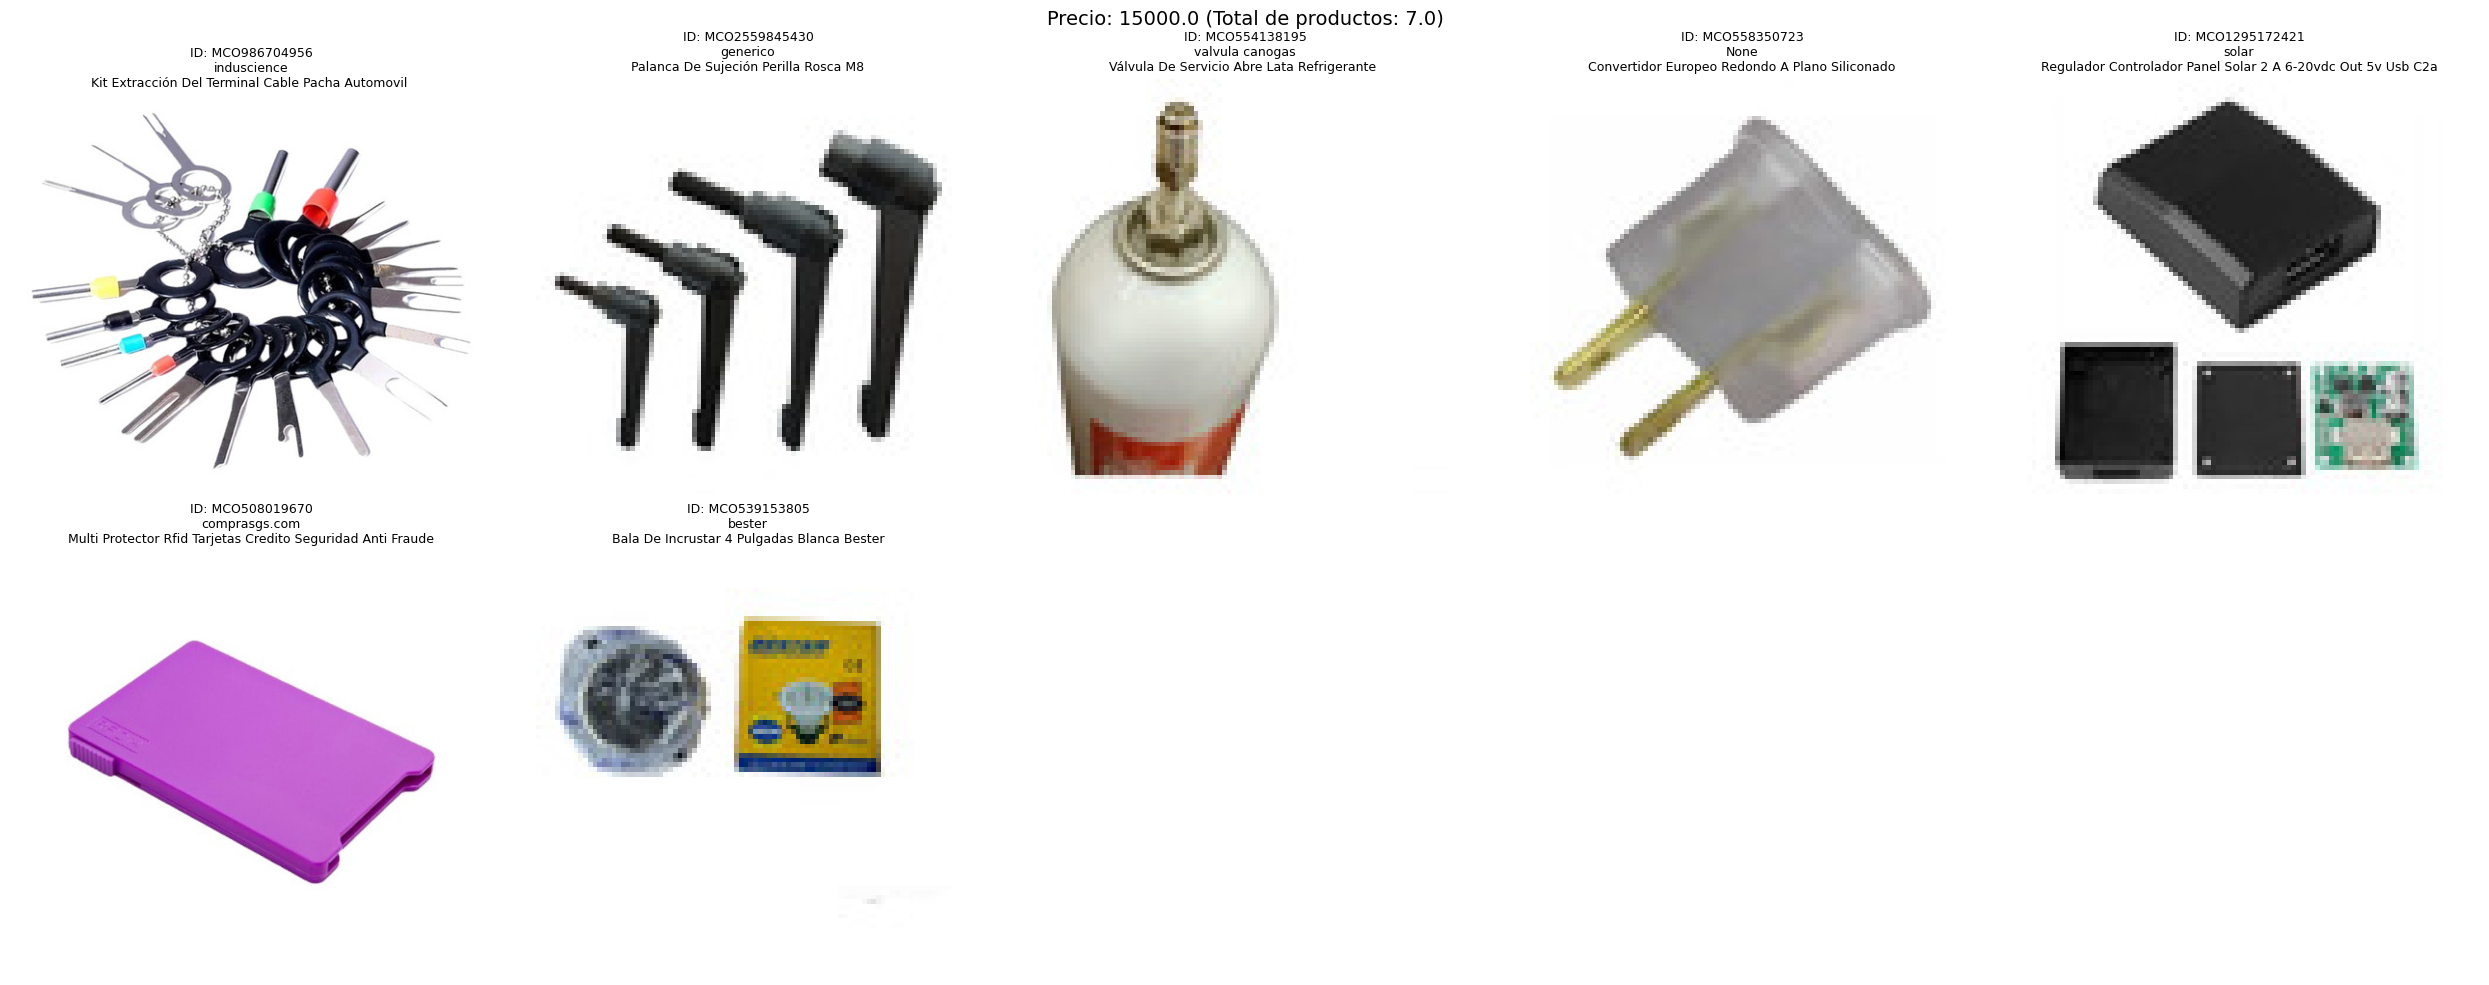


=== Precio: 79900.0 (Cantidad: 6.0) ===


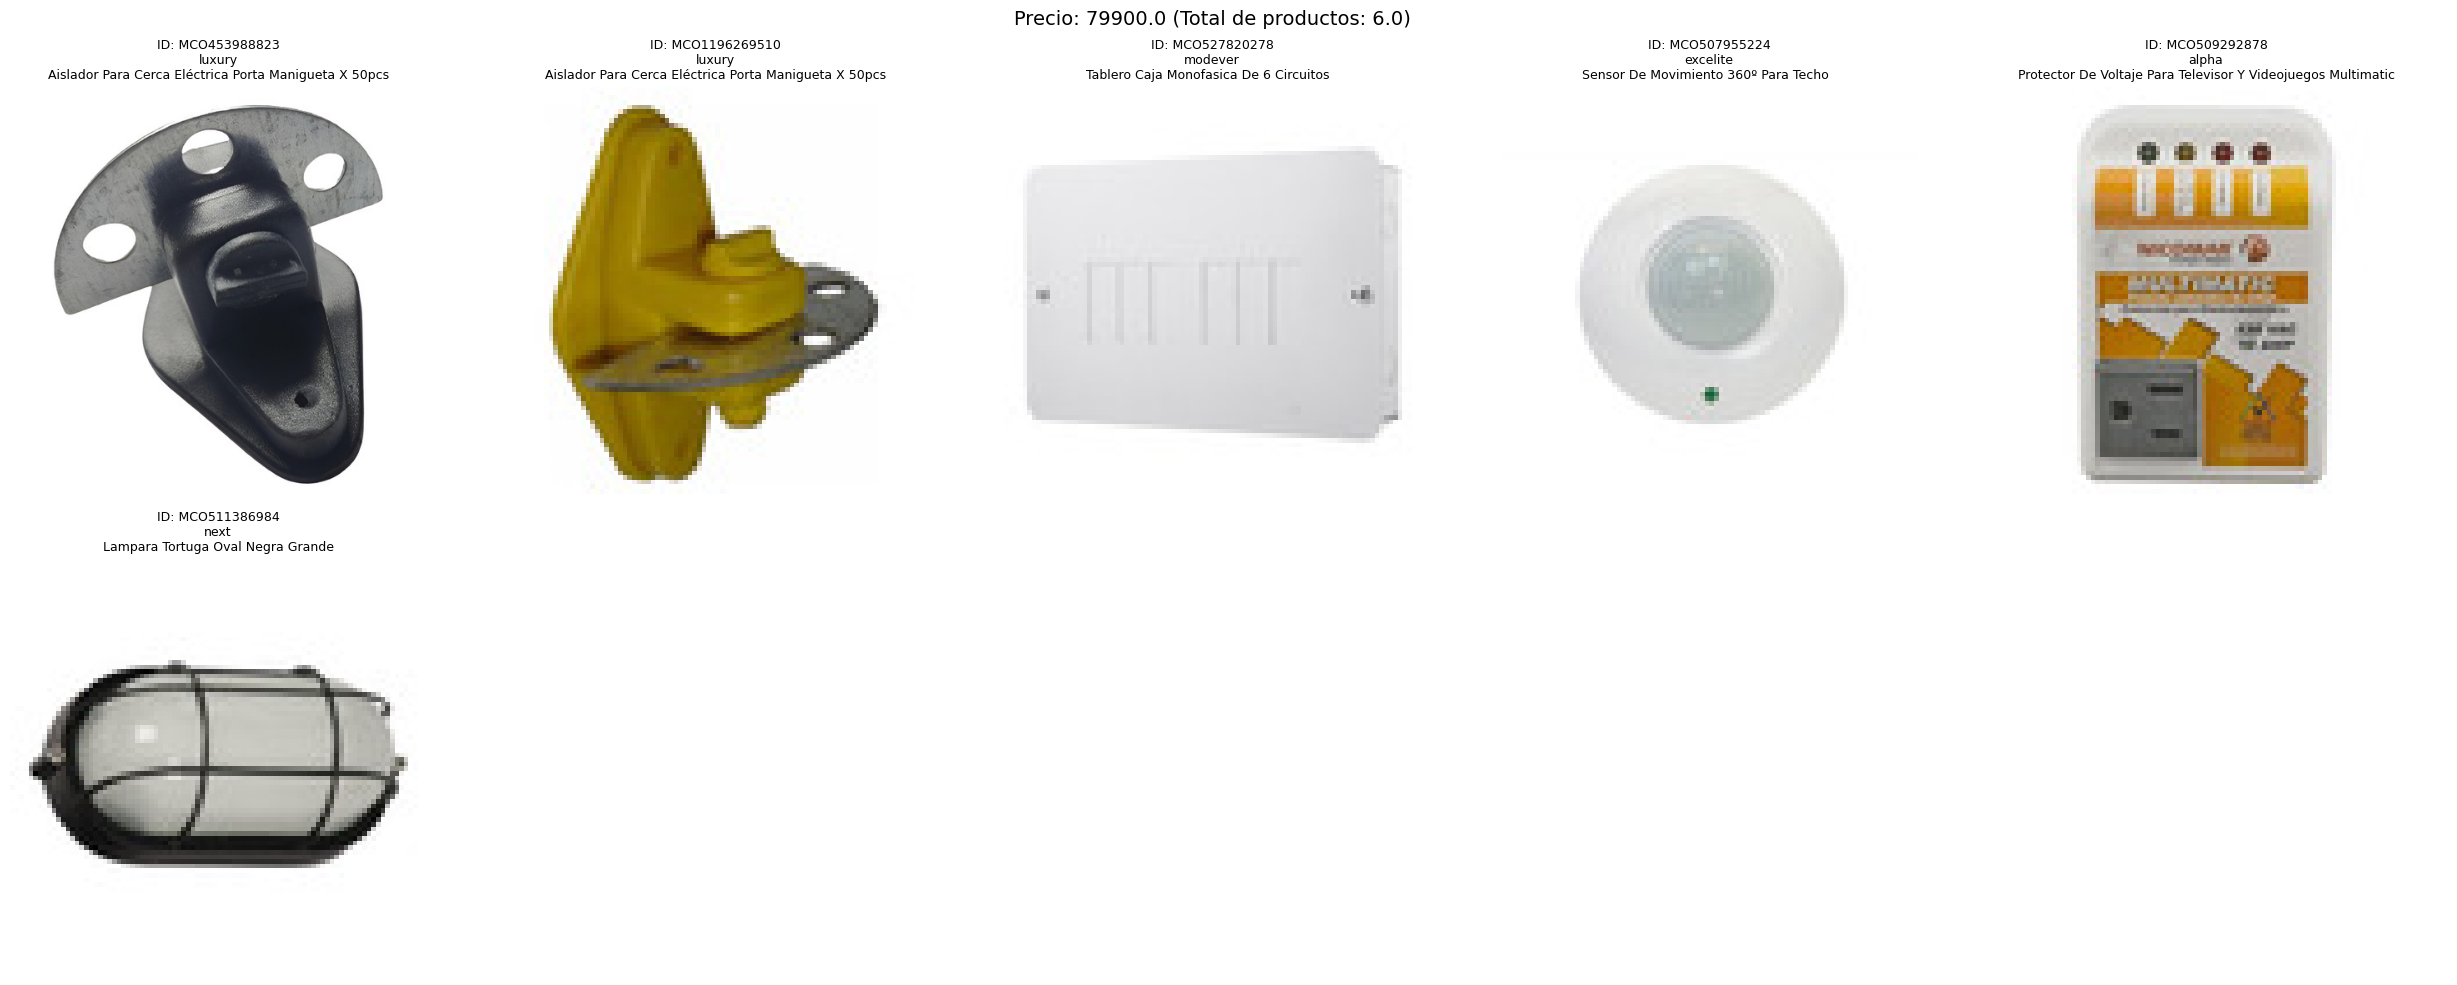

In [16]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import math
import numpy as np

def download_image(url):
    """
    Descarga la imagen desde 'url' y retorna un objeto PIL Image o None si falla.
    """
    try:
        resp = requests.get(url, timeout=5)
        if resp.status_code == 200:
            return Image.open(BytesIO(resp.content))
    except:
        pass
    return None

# Contar la cantidad de productos por precio
price_counts = df['price_std'].value_counts().reset_index()
price_counts.columns = ['price_std', 'count']

# Seleccionar los 5 precios con más productos
top_5_prices = price_counts.head(5)

# Graficar los productos asociados a cada precio
for i, row in top_5_prices.iterrows():
    price_val = row['price_std']
    count = row['count']
    
    print(f"\n=== Precio: {price_val} (Cantidad: {count}) ===")
    
    # Filtrar productos asociados al precio actual
    group = df[df['price_std'] == price_val]
    
    # Calcular filas y columnas para subplots
    max_cols = 5
    cols = min(len(group), max_cols)
    rows = math.ceil(len(group) / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    if rows == 1 and cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    fig.suptitle(f"Precio: {price_val} (Total de productos: {count})", fontsize=14)
    
    for j, (idx, product) in enumerate(group.iterrows()):
        ax = axes[j]
        thumbnail = product.get('thumbnail', None)
        product_id = product.get('id', 'N/A')
        brand = product.get('brand_std', 'desconocido')
        title = product.get('title', '(sin título)')
        img = None
        
        if isinstance(thumbnail, str) and thumbnail.strip():
            img = download_image(thumbnail)
        
        if img:
            ax.imshow(img)
            ax.set_title(f"ID: {product_id}\n{brand}\n{title}", fontsize=9)
        else:
            ax.text(0.5, 0.5, "No image", ha='center', va='center', fontsize=10)
            ax.set_title(f"ID: {product_id}\n{brand}\n{title}", fontsize=9)
        
        ax.axis('off')
    
    # Desactivar subplots sobrantes si n < rows*cols
    total_subplots = rows * cols
    if len(group) < total_subplots:
        for k in range(len(group), total_subplots):
            axes[k].axis('off')
    
    plt.tight_layout()
    plt.show()



Images

# Descargar y Visualizar Imágenes de Productos

## Obtener datos desde el DataFrame
Selecciona una fila específica del DataFrame para obtener:
- La URL de la imagen del producto (columna `thumbnail`).
- El título del producto (columna `title`).

## Descargar la imagen
Usa la librería `requests` para descargar la imagen desde la URL:
- Verifica que la solicitud sea exitosa (`status_code == 200`).
- Convierte el contenido de la respuesta a una imagen usando `PIL.Image`.

## Visualizar la imagen
Usa `matplotlib` para mostrar la imagen junto con el título del producto:
- Oculta los ejes (`plt.axis('off')`) para destacar la imagen.
- Añade el título del producto sobre la imagen con `plt.title`.
- Usa `wrap=True` si el título es muy largo para ajustarlo automáticamente.


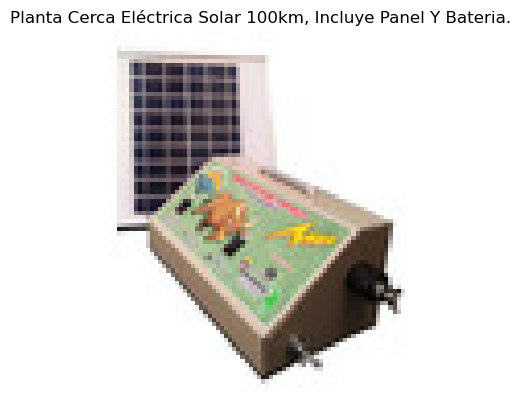

In [17]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Supongamos que quieres ver el producto en la fila 'index'
index = 3

# Obtener la URL y el título desde el DataFrame
image_url = df.loc[index, 'thumbnail']
product_title = df.loc[index, 'title']

# Descargar la imagen con requests
response = requests.get(image_url, timeout=5)
if response.status_code == 200:
    # Convertir el contenido a un objeto PIL Image
    img = Image.open(BytesIO(response.content))
    
    # Visualizar con matplotlib
    plt.figure()        # Ajustar tamaño si se desea
    plt.imshow(img)
    plt.axis('off')                  # Ocultar ejes
    plt.title(product_title, wrap=True)  # Usar wrap=True para ajustar si es muy largo
    plt.show()
else:
    print("No se pudo descargar la imagen. Código HTTP:", response.status_code)



=== Thumbnail: http://http2.mlstatic.com/D_836556-MCO73999808203_012024-I.jpg (Cantidad: 9) ===


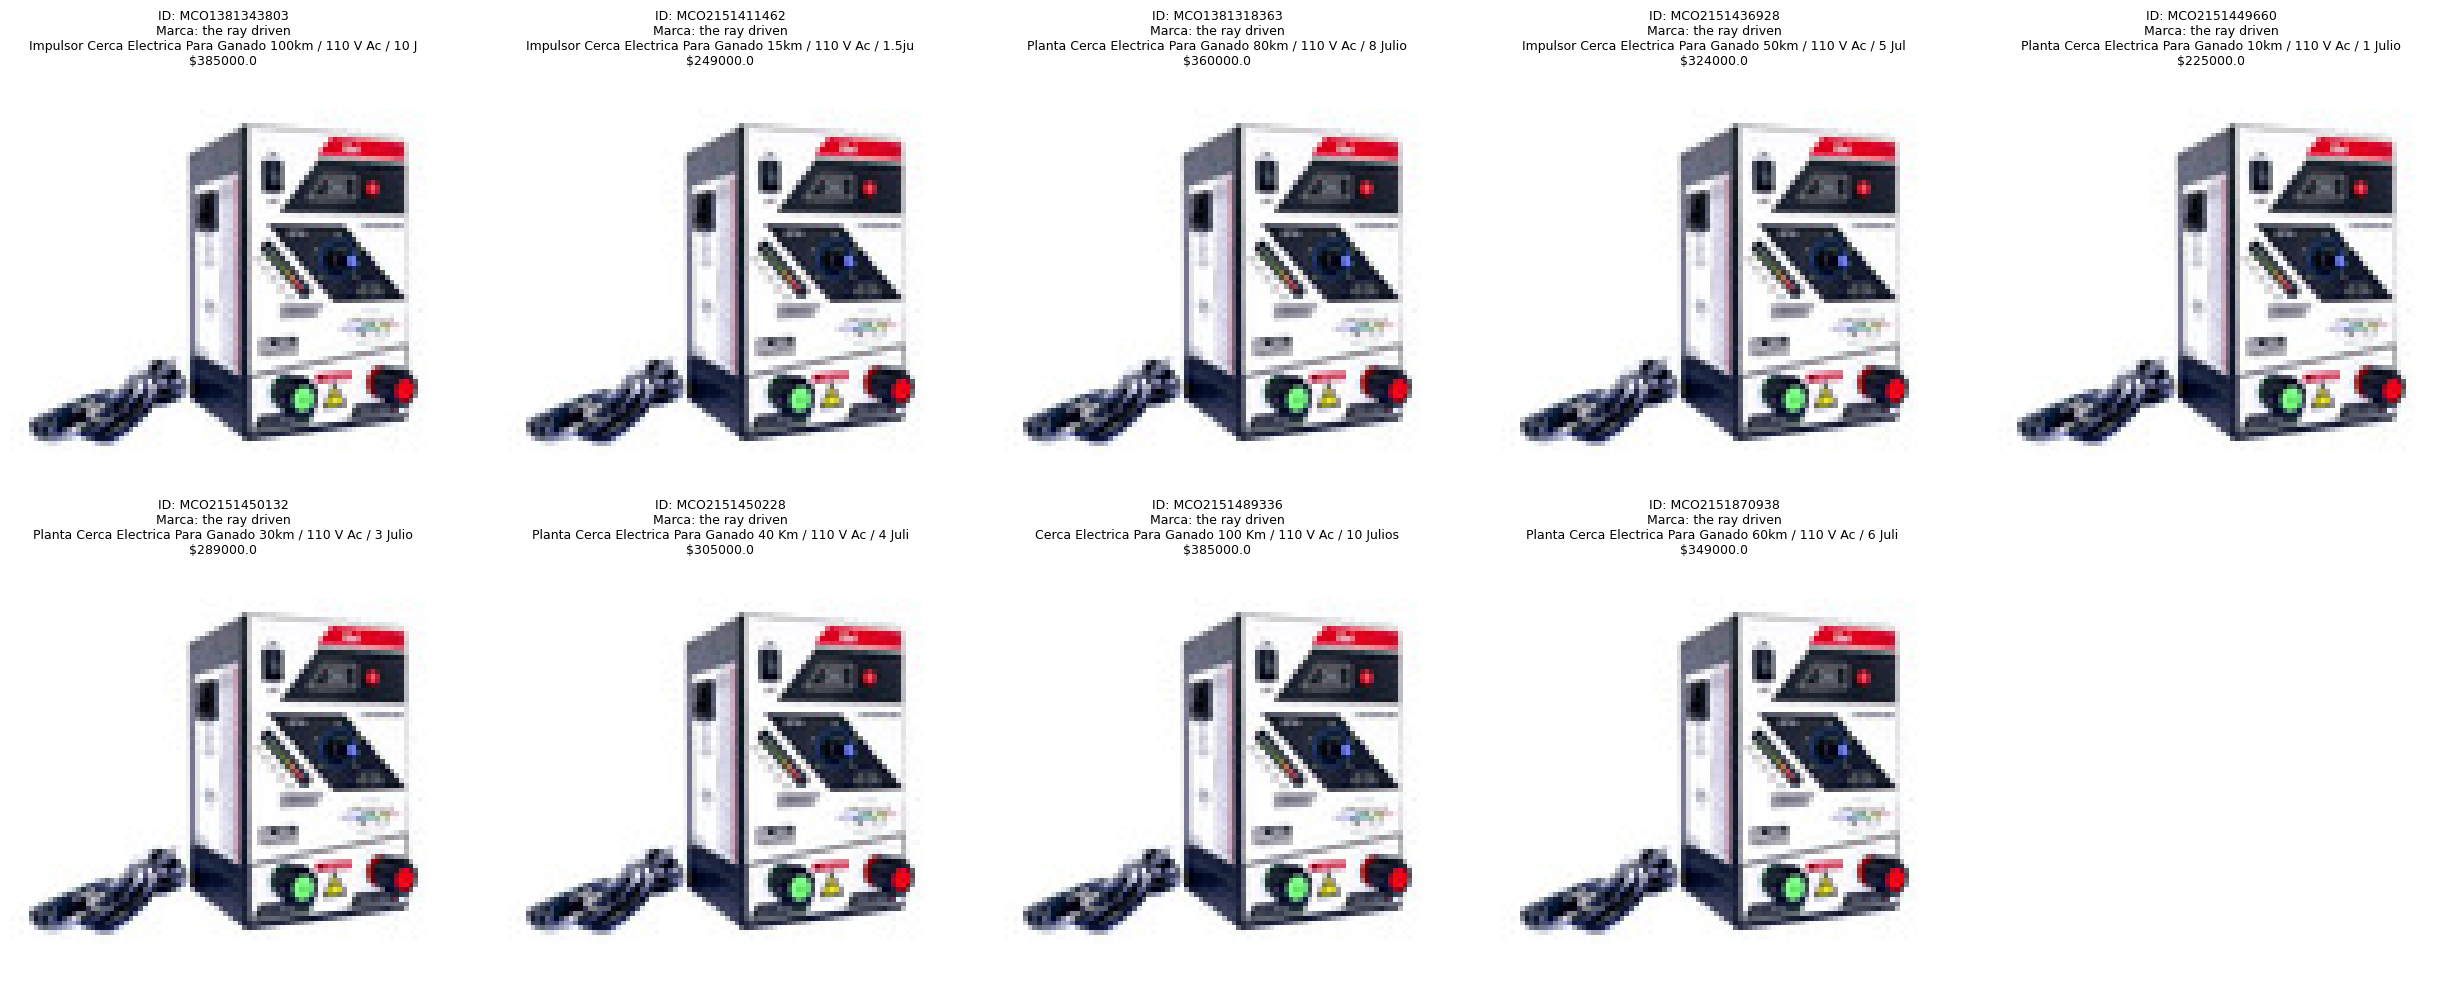


=== Thumbnail: http://http2.mlstatic.com/D_917987-MCO45216767518_032021-I.jpg (Cantidad: 4) ===


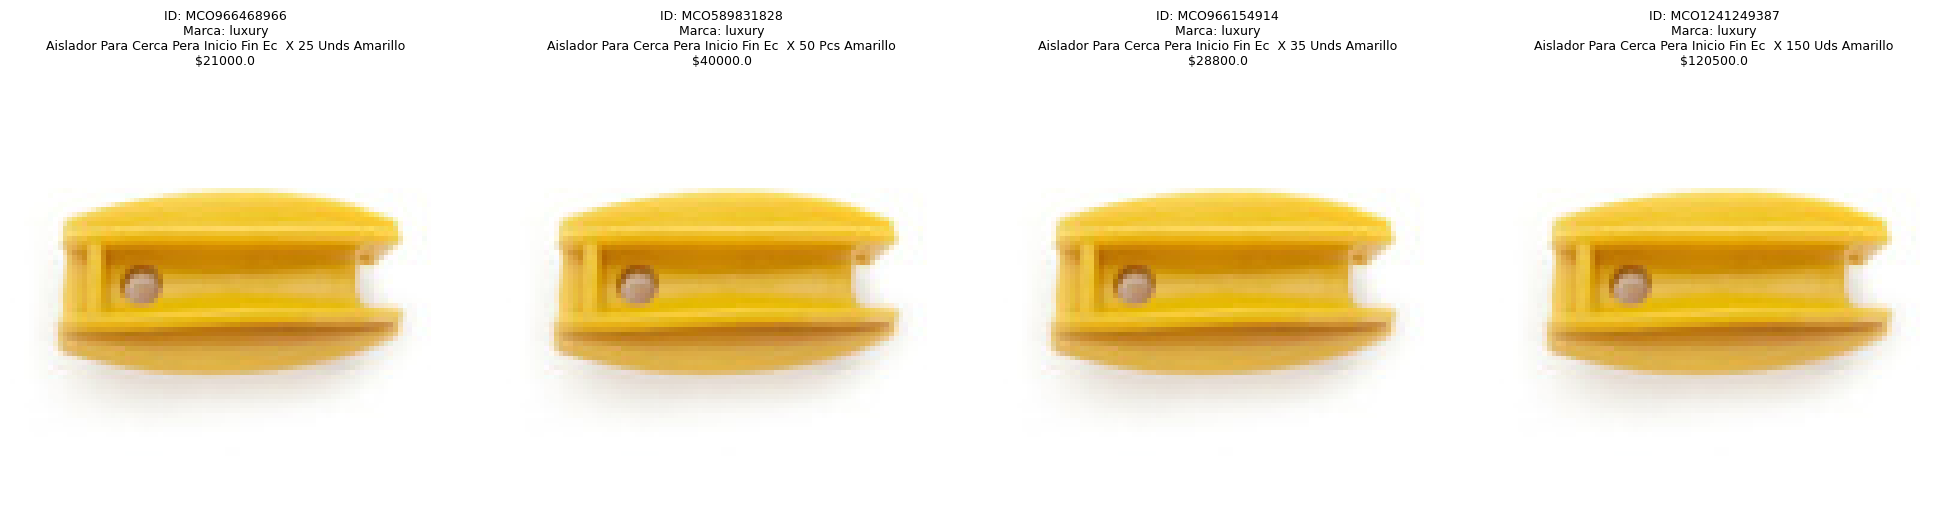


=== Thumbnail: http://http2.mlstatic.com/D_982535-MCO74020080147_012024-I.jpg (Cantidad: 4) ===


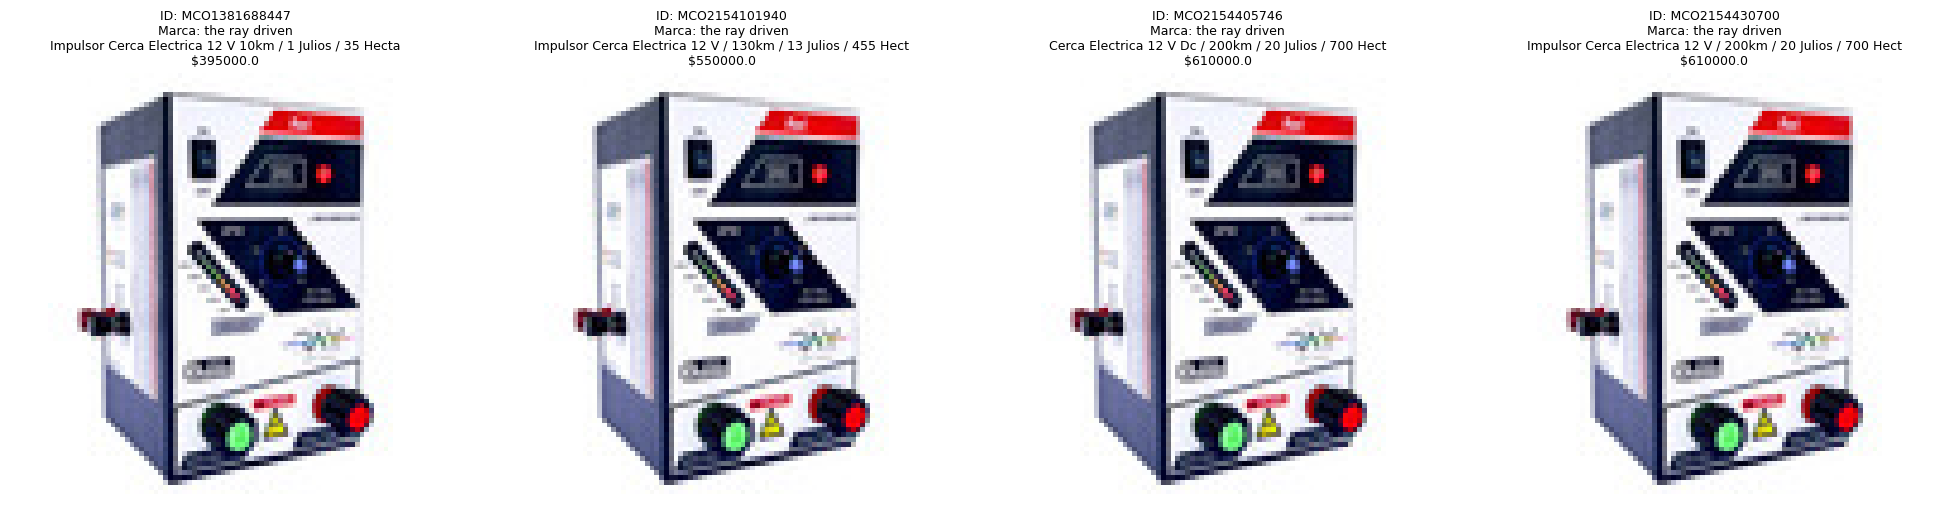


=== Thumbnail: http://http2.mlstatic.com/D_935418-MCO74002326045_012024-I.jpg (Cantidad: 4) ===


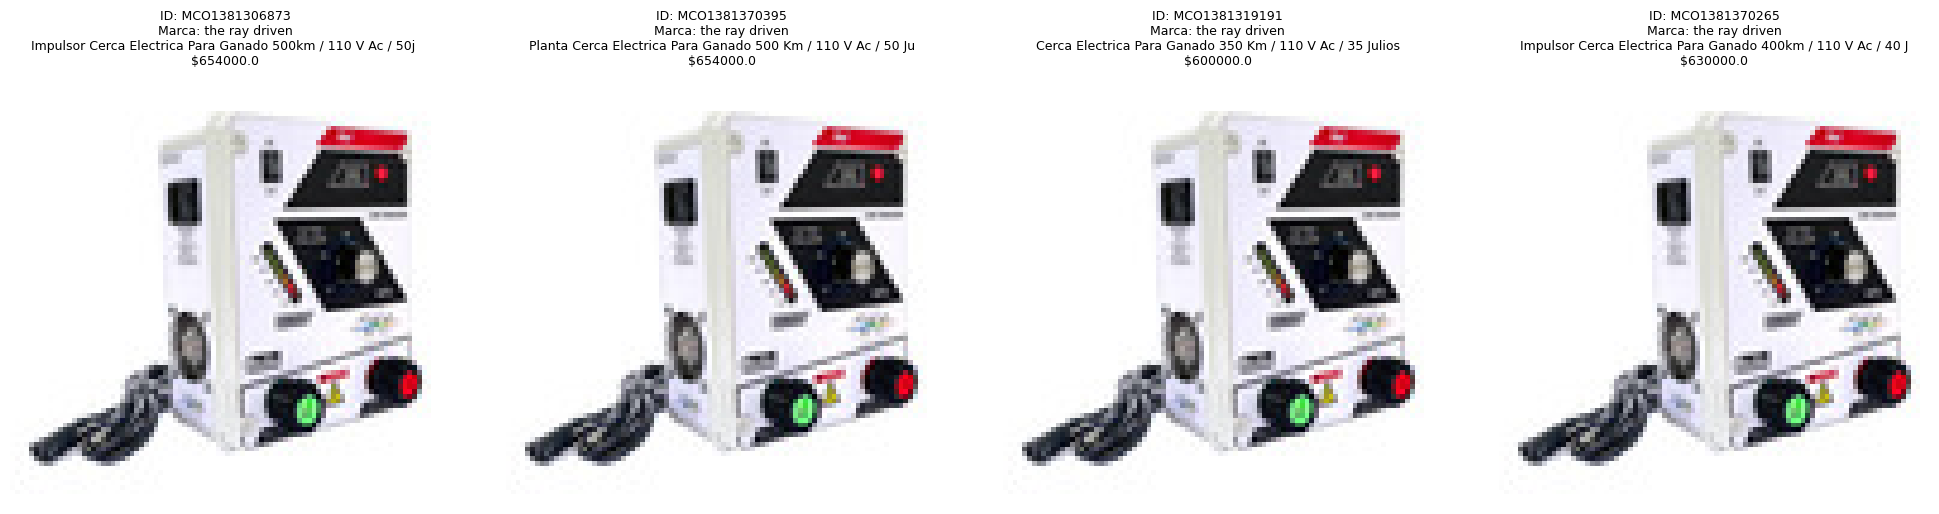


=== Thumbnail: http://http2.mlstatic.com/D_795299-MCO73913281082_012024-I.jpg (Cantidad: 3) ===


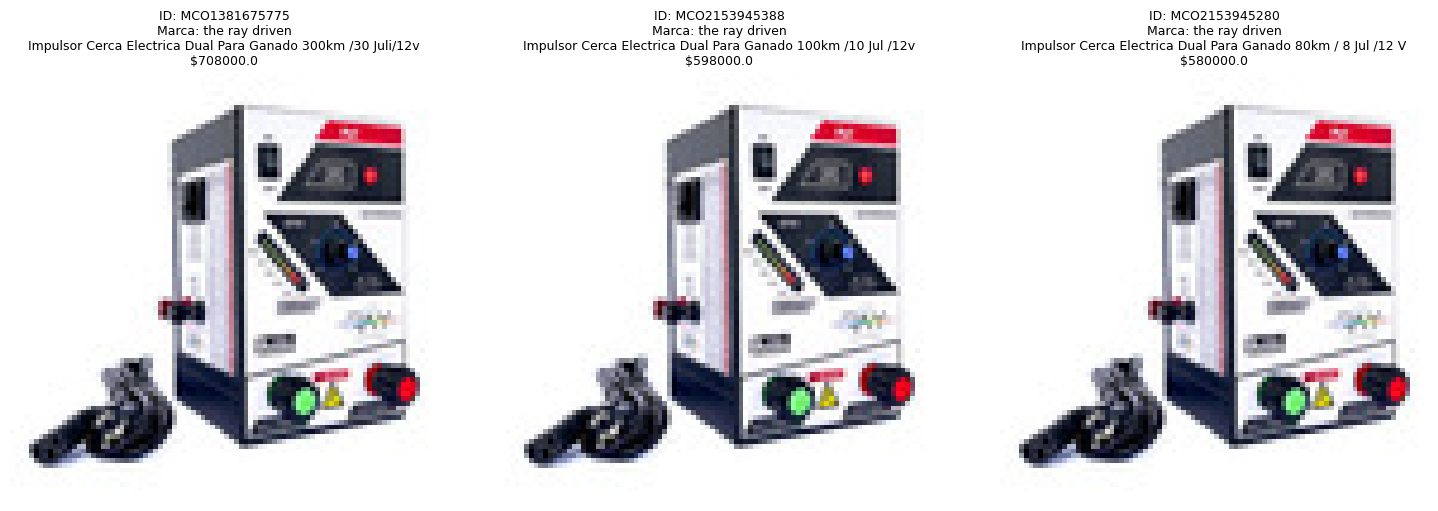

In [18]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import math

def download_image(url):
    """
    Descarga la imagen desde 'url' y retorna un objeto PIL Image o None si falla.
    """
    try:
        resp = requests.get(url, timeout=5)
        if resp.status_code == 200:
            return Image.open(BytesIO(resp.content))
    except:
        pass
    return None

# Contar la cantidad de productos por cada thumbnail
thumbnail_counts = df['thumbnail'].value_counts().reset_index()
thumbnail_counts.columns = ['thumbnail', 'count']

# Seleccionar los 5 thumbnails con más productos
top_5_thumbnails = thumbnail_counts.head(5)

# Graficar los thumbnails con más productos
for i, row in top_5_thumbnails.iterrows():
    thumb_val = row['thumbnail']
    count = row['count']
    
    print(f"\n=== Thumbnail: {thumb_val} (Cantidad: {count}) ===")
    
    # Filtrar productos asociados al thumbnail actual
    group = df[df['thumbnail'] == thumb_val]
    
    # Calcular filas y columnas para subplots
    max_cols = 5
    cols = min(len(group), max_cols)
    rows = math.ceil(len(group) / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    if rows == 1 and cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for j, (idx, product) in enumerate(group.iterrows()):
        ax = axes[j]
        img = download_image(thumb_val)
        title = product.get('title', '(sin título)')
        brand = product.get('brand_std', 'desconocido')
        price = product.get('price_std', '(sin precio)')
        product_id = product.get('id', 'N/A')

        if img:
            ax.imshow(img)
            ax.set_title(f"ID: {product_id}\nMarca: {brand}\n{title}\n${price}", fontsize=9)
        else:
            ax.text(0.5, 0.5, "No image", ha='center', va='center', fontsize=10)
            ax.set_title(f"ID: {product_id}\nMarca: {brand}\n{title}\n${price}", fontsize=9)
        
        ax.axis('off')
    
    # Ocultar subplots sobrantes
    total_subplots = rows * cols
    if len(group) < total_subplots:
        for k in range(len(group), total_subplots):
            axes[k].axis('off')
    
    plt.tight_layout()
    plt.show()



## Conclusión / Observaciones

- **Si el título y el thumbnail coinciden** (textos y foto idénticos), es muy probable que estemos ante el mismo producto (salvo que el vendedor cambie internamente alguna característica).  
- **Si solo coincide el thumbnail**, podría ser el mismo producto o variantes muy cercanas; conviene revisar título/marca para confirmarlo.  
- **Si el GTIN coincide y el resto no es contradictorio**, es la señal más fuerte de que se trata del mismo producto.  
- **El precio** puede variar de forma notable entre vendedores, así que no es definitivo para descartar la equivalencia.

Al final, el **enfoque más sólido** es combinar **varios atributos** (texto, marca, precio, imágenes) de manera ponderada o mediante un **modelo de similitud** que tome en cuenta estas señales, en lugar de depender estrictamente de uno solo.

In [19]:
# Crear carpeta processed si no existe
import os
if not os.path.exists('../data/processed'):
    os.makedirs('../data/processed')

# Guardar el DataFrame procesado a CSV
df.to_csv('../data/processed/productos_limpios.csv', index=False)
print("DataFrame guardado exitosamente en '../data/processed/productos_limpios.csv'")


DataFrame guardado exitosamente en '../data/processed/productos_limpios.csv'
